## Libraries

In [30]:
import pandas as pd 
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
from neo4j import GraphDatabase
from pm4py.objects.log.log import EventLog
from collections import Counter
import pm4py
import matplotlib.pyplot as plt 
from pm4py.statistics.traces.log import case_statistics
from pm4py import stats
import plotly.graph_objects as go

## connection to Neo4J database

In [31]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("Username", "Password"))
session = driver.session()

## Get cases from the graph database

In [57]:
query = f'''
//match (r:Run {{EntityType:"Kit", numberOfPieces: 1}}) <- [:CORR] - (e1:Event {{Activity:"Entrada Material Sucio"}}) - [:DF_CASE] -> 
//(e2:Event {{Activity:"Cargado en carro L+D"}}) 
//match (r) <- [:CORR] - (e2) - [:DF_CASE] -> (e3:Event {{Activity:"Carga L+D iniciada"}})
//match (r) <- [:CORR] - (e3) - [:DF_CASE] -> (e4:Event {{Activity:"Carga L+D liberada"}}) 
//match (r) <- [:CORR] - (e4) - [:DF_CASE] -> (e5:Event {{Activity:"Montaje"}}) 
//match (r) <- [:CORR] - (e5) - [:DF_CASE] -> (e6:Event {{Activity:"Producción montada"}})
//match (r) <- [:CORR] - (e6) - [:DF_CASE] -> (e7:Event {{Activity:"Composición de cargas"}})
//match (r) <- [:CORR] - (e7) - [:DF_CASE] -> (e8:Event {{Activity:"Carga de esterilizador liberada"}}) 
//where r.durationInMinutes = 0 
//or e1.timestamp.day <> e2.timestamp.day 
//or e3.timestamp.day <> e2.timestamp.day 
//or e3.timestamp.day <> e4.timestamp.day
//or e4.timestamp.day <> e5.timestamp.day
//or e5.timestamp.day <> e6.timestamp.day
//or e6.timestamp.day <> e7.timestamp.day
//or e7.timestamp.day <> e8.timestamp.day
//with r
match (e:Event) - [:CORR] -> (r:Run)
where not e.KitID contains "CONT"
return r.CaseID as CaseID, e.Activity, e.Nombre, e.KitID, e.Usuario as resource, e.timestamp, e.`Código`, e.NS '''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
df = pd.DataFrame(records, columns=columns)
df['e.timestamp'] = pd.to_datetime(df['e.timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
df = df.sort_values(by='e.timestamp')
df.head()

,CaseID,e.Activity,e.Nombre,e.KitID,resource,e.timestamp,e.`Código`,e.NS
104349,EXT-GAFAS-0-CN0,Carga L+D liberada,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:09:00+00:00,EXT-GAFAS,0
104350,EXT-GAFAS-0-CN0,Comisionado,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:18:00+00:00,EXT-GAFAS,0
25337,EXT-GAFAS-0-CN1,Comisionado,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:19:00+00:00,EXT-GAFAS,0
25336,EXT-GAFAS-0-CN2,Comisionado,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:20:00+00:00,EXT-GAFAS,0
88102,HUBU-URG.005-3-CN4,Entrada Material Sucio,SET DE URGENCIAS 03,HUBU-URG.005-3,MCE,2022-01-01 07:21:00+00:00,HUBU-URG.005,3


In [58]:
query = f'''
match (e:Event)
where not e.KitID contains "CONT"
return e.CaseID as CaseID, e.Activity, e.Nombre, e.KitID, e.Usuario as resource, e.timestamp, e.`Código`, e.NS '''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
df2 = pd.DataFrame(records, columns=columns)
df2['e.timestamp'] = pd.to_datetime(df2['e.timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
df2 = df2.sort_values(by='e.timestamp')
df2.head()

,CaseID,e.Activity,e.Nombre,e.KitID,resource,e.timestamp,e.`Código`,e.NS
44560,EXT-GAFAS-0-CN0,Carga L+D liberada,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:09:00+00:00,EXT-GAFAS,0
203902,EXT-GAFAS-0-CN0,Comisionado,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:18:00+00:00,EXT-GAFAS,0
203901,EXT-GAFAS-0-CN1,Comisionado,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:19:00+00:00,EXT-GAFAS,0
203900,EXT-GAFAS-0-CN2,Comisionado,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:20:00+00:00,EXT-GAFAS,0
7735,HUBU-URG.005-8-CN3,Entrada Material Sucio,SET DE URGENCIAS COMPLEJO 08,HUBU-URG.005-8,MCE,2022-01-01 07:21:00+00:00,HUBU-URG.005,8


In [62]:
# Select the columns for comparison
columns_to_compare = ['CaseID', 'e.Activity', 'e.Nombre', 'e.KitID', 'resource', 'e.timestamp', 'e.`Código`', 'e.NS']

# Filter the DataFrames to include only the selected columns
df1_filtered = df[columns_to_compare]
df2_filtered = df2[columns_to_compare]

df1_filtered.reset_index(drop=True, inplace=True)
df2_filtered.reset_index(drop=True, inplace=True)

# Check for equality
are_equal = df1_filtered.equals(df2_filtered)
print('DataFrames are equal:', are_equal)

# Find differences
comparison = df1_filtered.compare(df2_filtered, keep_shape=True, keep_equal=True)
print('Comparison of DataFrames:')
print(comparison)

# Merging DataFrames on the selected columns
merged_df = pd.merge(df1_filtered, df2_filtered, on=columns_to_compare, how='outer', indicator=True)
print('Merged DataFrame with indicator:')
print(merged_df)

# Finding rows in df1 but not in df2
diff_df1 = df1_filtered[~df1_filtered.isin(df2_filtered.to_dict(orient='list')).all(axis=1)]
print('Rows in df1 but not in df2:')
print(diff_df1)

# Finding rows in df2 but not in df1
diff_df2 = df2_filtered[~df2_filtered.isin(df1_filtered.to_dict(orient='list')).all(axis=1)]
print('Rows in df2 but not in df1:')
print(diff_df2)


DataFrames are equal: False
Comparison of DataFrames:
                             CaseID                               \
                               self                        other   
0                   EXT-GAFAS-0-CN0              EXT-GAFAS-0-CN0   
1                   EXT-GAFAS-0-CN0              EXT-GAFAS-0-CN0   
2                   EXT-GAFAS-0-CN1              EXT-GAFAS-0-CN1   
3                   EXT-GAFAS-0-CN2              EXT-GAFAS-0-CN2   
4                HUBU-URG.005-3-CN4           HUBU-URG.005-8-CN3   
...                             ...                          ...   
205811  EXT-QUI.OMS800.04-0-CN34446        HNB-OFT.002-1-CN35471   
205812  EXT-QUI.OMS800.04-0-CN34446       HNB-OFT.002-18-CN35472   
205813  EXT-QUI.OMS800.02-0-CN35206        EXT-QUI.002-0-CN34448   
205814     EXT-QUI.495NCS-0-CN35212  EXT-QUI.OMS800.02-0-CN35206   
205815          EXT-GAFAS-0-CN26611          EXT-GAFAS-0-CN26611   

                    e.Activity                          \
   

In [76]:
ch = df[df['CaseID'] == 'EXT-QUI.004-0-CN33862']
ch = ch.sort_values(by= 'e.timestamp')
ch.head(10)

,CaseID,e.Activity,e.Nombre,e.KitID,resource,e.timestamp,e.`Código`,e.NS
107642,EXT-QUI.004-0-CN33862,Producción montada,MANGO LAMPARA,EXT-QUI.004-0,ER,2022-03-27 09:20:00+00:00,EXT-QUI.004,0
107697,EXT-QUI.004-0-CN33862,Producción montada,MANGO LAMPARA,EXT-QUI.004-0,ER,2022-03-27 09:20:00+00:00,EXT-QUI.004,0
107694,EXT-QUI.004-0-CN33862,Montaje,MANGO LAMPARA,EXT-QUI.004-0,ER,2022-03-27 09:20:00+00:00,EXT-QUI.004,0
107647,EXT-QUI.004-0-CN33862,Montaje,MANGO LAMPARA,EXT-QUI.004-0,ER,2022-03-27 09:20:00+00:00,EXT-QUI.004,0
107637,EXT-QUI.004-0-CN33862,Producción montada,MANGO LAMPARA,EXT-QUI.004-0,ER,2022-03-27 09:20:00+00:00,EXT-QUI.004,0
107662,EXT-QUI.004-0-CN33862,Composición de cargas,MANGO LAMPARA,EXT-QUI.004-0,ER,2022-03-27 09:52:00+00:00,EXT-QUI.004,0
107639,EXT-QUI.004-0-CN33862,Composición de cargas,MANGO LAMPARA,EXT-QUI.004-0,ER,2022-03-27 09:52:00+00:00,EXT-QUI.004,0
107673,EXT-QUI.004-0-CN33862,Composición de cargas,MANGO LAMPARA,EXT-QUI.004-0,ER,2022-03-27 09:52:00+00:00,EXT-QUI.004,0
107652,EXT-QUI.004-0-CN33862,Carga de esterilizador liberada,MANGO LAMPARA,EXT-QUI.004-0,ER,2022-03-27 11:35:00+00:00,EXT-QUI.004,0
107692,EXT-QUI.004-0-CN33862,Carga de esterilizador liberada,MANGO LAMPARA,EXT-QUI.004-0,ER,2022-03-27 11:35:00+00:00,EXT-QUI.004,0


In [77]:
ch2 = df2[df2['CaseID'] == 'EXT-QUI.004-0-CN33862']
ch2 = ch2.sort_values(by= 'e.timestamp', inplace= True)
ch2.head(10)

,CaseID,e.Activity,e.Nombre,e.KitID,resource,e.timestamp,e.`Código`,e.NS
46233,EXT-QUI.004-0-CN33862,Montaje,MANGO LAMPARA,EXT-QUI.004-0,ER,2022-03-27 09:20:00+00:00,EXT-QUI.004,0
46232,EXT-QUI.004-0-CN33862,Montaje,MANGO LAMPARA,EXT-QUI.004-0,ER,2022-03-27 09:20:00+00:00,EXT-QUI.004,0
70824,EXT-QUI.004-0-CN33862,Producción montada,MANGO LAMPARA,EXT-QUI.004-0,ER,2022-03-27 09:20:00+00:00,EXT-QUI.004,0
70823,EXT-QUI.004-0-CN33862,Producción montada,MANGO LAMPARA,EXT-QUI.004-0,ER,2022-03-27 09:20:00+00:00,EXT-QUI.004,0
70822,EXT-QUI.004-0-CN33862,Producción montada,MANGO LAMPARA,EXT-QUI.004-0,ER,2022-03-27 09:20:00+00:00,EXT-QUI.004,0
108788,EXT-QUI.004-0-CN33862,Composición de cargas,MANGO LAMPARA,EXT-QUI.004-0,ER,2022-03-27 09:52:00+00:00,EXT-QUI.004,0
108787,EXT-QUI.004-0-CN33862,Composición de cargas,MANGO LAMPARA,EXT-QUI.004-0,ER,2022-03-27 09:52:00+00:00,EXT-QUI.004,0
108786,EXT-QUI.004-0-CN33862,Composición de cargas,MANGO LAMPARA,EXT-QUI.004-0,ER,2022-03-27 09:52:00+00:00,EXT-QUI.004,0
146516,EXT-QUI.004-0-CN33862,Carga de esterilizador liberada,MANGO LAMPARA,EXT-QUI.004-0,ER,2022-03-27 11:35:00+00:00,EXT-QUI.004,0
146517,EXT-QUI.004-0-CN33862,Carga de esterilizador liberada,MANGO LAMPARA,EXT-QUI.004-0,ER,2022-03-27 11:35:00+00:00,EXT-QUI.004,0


In [82]:
activity_mapping = {
    'Entrada Material Sucio': 1, 
    'Cargado en carro L+D': 2,
    'Carga L+D iniciada': 3,
    'Carga L+D liberada': 4,
    'Montaje': 5,
    'Producción montada': 6,
    'Composición de cargas': 7,
    'Carga de esterilizador liberada': 8,
    'Comisionado': 9
}

df2['e.Activity'] = df2['e.Activity'].map(activity_mapping)
df2.head()

,CaseID,e.Activity,e.Nombre,e.KitID,resource,e.timestamp,e.`Código`,e.NS
44560,EXT-GAFAS-0-CN0,4,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:09:00+00:00,EXT-GAFAS,0
203902,EXT-GAFAS-0-CN0,9,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:18:00+00:00,EXT-GAFAS,0
203901,EXT-GAFAS-0-CN1,9,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:19:00+00:00,EXT-GAFAS,0
203900,EXT-GAFAS-0-CN2,9,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:20:00+00:00,EXT-GAFAS,0
7735,HUBU-URG.005-8-CN3,1,SET DE URGENCIAS COMPLEJO 08,HUBU-URG.005-8,MCE,2022-01-01 07:21:00+00:00,HUBU-URG.005,8


In [94]:
df2.sort_values(by= ['e.timestamp', 'e.Activity', 'CaseID'], inplace= True)


In [95]:
df.head(25)

,CaseID,e.Activity,e.Nombre,e.KitID,resource,e.timestamp,e.`Código`,e.NS
104349,EXT-GAFAS-0-CN0,4,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:09:00+00:00,EXT-GAFAS,0
104350,EXT-GAFAS-0-CN0,9,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:18:00+00:00,EXT-GAFAS,0
25337,EXT-GAFAS-0-CN1,9,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:19:00+00:00,EXT-GAFAS,0
25336,EXT-GAFAS-0-CN2,9,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:20:00+00:00,EXT-GAFAS,0
88102,HUBU-URG.005-3-CN4,1,SET DE URGENCIAS 03,HUBU-URG.005-3,MCE,2022-01-01 07:21:00+00:00,HUBU-URG.005,3
88087,HUBU-URG.005-8-CN3,1,SET DE URGENCIAS COMPLEJO 08,HUBU-URG.005-8,MCE,2022-01-01 07:21:00+00:00,HUBU-URG.005,8
88105,HUBU-URG.006-1-CN5,1,CONSULTA URGENCIAS OFTALMOLOGIA,HUBU-URG.006-1,MCE,2022-01-01 07:21:00+00:00,HUBU-URG.006,1
88071,HNB-GIN.014-21-CN10,1,Partos 21,HNB-GIN.014-21,MCE,2022-01-01 07:46:00+00:00,HNB-GIN.014,21
88083,HNB-GIN.014-33-CN11,1,Partos 33,HNB-GIN.014-33,MCE,2022-01-01 07:46:00+00:00,HNB-GIN.014,33
88064,HNB-GIN.015-9-CN7,1,Forceps 09,HNB-GIN.015-9,MCE,2022-01-01 07:46:00+00:00,HNB-GIN.015,9


In [104]:
df2.head(25)

,CaseID,e.Activity,e.Nombre,e.KitID,resource,e.timestamp,e.`Código`,e.NS
0,EXT-GAFAS-0-CN0,4,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:09:00+00:00,EXT-GAFAS,0
1,EXT-GAFAS-0-CN0,9,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:18:00+00:00,EXT-GAFAS,0
2,EXT-GAFAS-0-CN1,9,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:19:00+00:00,EXT-GAFAS,0
3,EXT-GAFAS-0-CN2,9,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:20:00+00:00,EXT-GAFAS,0
4,HUBU-URG.005-3-CN4,1,SET DE URGENCIAS 03,HUBU-URG.005-3,MCE,2022-01-01 07:21:00+00:00,HUBU-URG.005,3
5,HUBU-URG.005-8-CN3,1,SET DE URGENCIAS COMPLEJO 08,HUBU-URG.005-8,MCE,2022-01-01 07:21:00+00:00,HUBU-URG.005,8
6,HUBU-URG.006-1-CN5,1,CONSULTA URGENCIAS OFTALMOLOGIA,HUBU-URG.006-1,MCE,2022-01-01 07:21:00+00:00,HUBU-URG.006,1
7,HNB-GIN.014-21-CN10,1,Partos 21,HNB-GIN.014-21,MCE,2022-01-01 07:46:00+00:00,HNB-GIN.014,21
8,HNB-GIN.014-33-CN11,1,Partos 33,HNB-GIN.014-33,MCE,2022-01-01 07:46:00+00:00,HNB-GIN.014,33
9,HNB-GIN.015-9-CN7,1,Forceps 09,HNB-GIN.015-9,MCE,2022-01-01 07:46:00+00:00,HNB-GIN.015,9


In [126]:
df.sort_values(by= ['e.timestamp', 'e.Activity', 'CaseID', 'e.NS', 'resource'], inplace= True)
df2.sort_values(by= ['e.timestamp', 'e.Activity', 'CaseID', 'e.NS', 'resource'], inplace= True)


df.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)


In [127]:
df.head()

,CaseID,e.Activity,e.Nombre,e.KitID,resource,e.timestamp,e.`Código`,e.NS
0,EXT-GAFAS-0-CN0,4,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:09:00+00:00,EXT-GAFAS,0
1,EXT-GAFAS-0-CN0,9,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:18:00+00:00,EXT-GAFAS,0
2,EXT-GAFAS-0-CN1,9,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:19:00+00:00,EXT-GAFAS,0
3,EXT-GAFAS-0-CN2,9,GAFAS - PANTALLAS,EXT-GAFAS-0,MCE,2022-01-01 07:20:00+00:00,EXT-GAFAS,0
4,HUBU-URG.005-3-CN4,1,SET DE URGENCIAS 03,HUBU-URG.005-3,MCE,2022-01-01 07:21:00+00:00,HUBU-URG.005,3


In [114]:
are_equal = df.equals(df2)
print('DataFrames are equal:', are_equal)

comparison = df.compare(df2, keep_shape=True, keep_equal=True)
print('Comparison of DataFrames:')
print(comparison)

merged_df = pd.merge(df, df2, on=columns_to_compare, how='outer', indicator=True)
print('Merged DataFrame with indicator:')
print(merged_df)

diff_df1 = df[~df.isin(df2.to_dict(orient='list')).all(axis=1)]
print('Rows in df1 but not in df2:')
print(diff_df1)

diff_df2 = df2[~df2.isin(df.to_dict(orient='list')).all(axis=1)]
print('Rows in df2 but not in df1:')
print(diff_df2)


DataFrames are equal: False
Comparison of DataFrames:
                        CaseID                         e.Activity        \
                          self                   other       self other   
0              EXT-GAFAS-0-CN0         EXT-GAFAS-0-CN0          4     4   
1              EXT-GAFAS-0-CN0         EXT-GAFAS-0-CN0          9     9   
2              EXT-GAFAS-0-CN1         EXT-GAFAS-0-CN1          9     9   
3              EXT-GAFAS-0-CN2         EXT-GAFAS-0-CN2          9     9   
4           HUBU-URG.005-3-CN4      HUBU-URG.005-3-CN4          1     1   
...                        ...                     ...        ...   ...   
205811  HNB-OFT.002-18-CN35472  HNB-OFT.002-18-CN35472          7     7   
205812   HNB-OFT.002-6-CN35469   HNB-OFT.002-6-CN35469          7     7   
205813   HNB-OFT.002-8-CN35468   HNB-OFT.002-8-CN35468          7     7   
205814   HNB-OFT.002-9-CN35470   HNB-OFT.002-9-CN35470          7     7   
205815     EXT-GAFAS-0-CN26611     EXT-GAFAS-0

In [125]:
comparisondf = df.compare(df2, keep_shape=True, keep_equal=True)
different_rows = comparisondf[(df['resource'] != df2['resource'])
                                 ]
different_rows.head()

CaseID                        e.Activity        \
                        self                  other       self other   
5843    HNB-GIN.014-1-CN1303   HNB-GIN.014-1-CN1303          3     3   
5844    HNB-GIN.014-1-CN1303   HNB-GIN.014-1-CN1303          3     3   
5845    HNB-GIN.014-2-CN1302   HNB-GIN.014-2-CN1302          3     3   
5846    HNB-GIN.014-2-CN1302   HNB-GIN.014-2-CN1302          3     3   
16523  EXT-QUI.GOMA-0-CN3177  EXT-QUI.GOMA-0-CN3177          6     6   

        e.Nombre                    e.KitID                 resource        \
            self      other            self           other     self other   
5843   Partos 01  Partos 01   HNB-GIN.014-1   HNB-GIN.014-1       AV    MR   
5844   Partos 01  Partos 01   HNB-GIN.014-1   HNB-GIN.014-1       MR    AV   
5845   Partos 02  Partos 02   HNB-GIN.014-2   HNB-GIN.014-2       MR    AV   
5846   Partos 02  Partos 02   HNB-GIN.014-2   HNB-GIN.014-2       AV    MR   
16523  TUBO GOMA  TUBO GOMA  EXT-QUI.GOMA-0  EXT-QUI.GOMA-0       ML    BM   

                    e.timestamp                              e.`Código`  \
                           self                     other          self   
5843  2022-01-04 21:43:00+00:00 2022-01-04 21:43:00+00:00   HNB-GIN.014   
5844  2022-01-04 21:43:00+00:00 2022-01-04 21:43:00+00:00   HNB-GIN.014   
5845  2022-01-04 21:43:00+00:00 2022-01-04 21:43:00+00:00   HNB-GIN.014   
5846  2022-01-04 21:43:00+00:00 2022-01-04 21:43:00+00:00   HNB-GIN.014   
16523 2022-01-11 17:10:00+00:00 2022-01-11 17:10:00+00:00  EXT-QUI.GOMA   

                    e.NS        
              other self other  
5843    HNB-GIN.014    1     1  
5844    HNB-GIN.014    1     1  
5845    HNB-GIN.014    2     2  
5846    HNB-GIN.014    2     2  
16523  EXT-QUI.GOMA    0     0

In [80]:
ch.reset_index(drop=True, inplace=True)
ch2.reset_index(drop=True, inplace=True)

are_equal = ch.equals(ch2)
print('DataFrames are equal:', are_equal)

comparison = ch.compare(ch2, keep_shape=True, keep_equal=True)
comparison.head(50)


DataFrames are equal: False


CaseID                         \
                     self                  other   
0   EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
1   EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
2   EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
3   EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
4   EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
5   EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
6   EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
7   EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
8   EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
9   EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
10  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
11  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
12  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
13  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
14  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
15  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
16  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
17  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
18  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
19  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
20  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
21  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
22  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
23  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
24  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
25  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
26  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
27  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
28  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
29  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
30  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
31  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
32  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
33  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
34  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
35  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
36  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
37  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
38  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
39  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
40  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
41  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
42  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
43  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
44  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
45  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
46  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
47  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
48  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   
49  EXT-QUI.004-0-CN33862  EXT-QUI.004-0-CN33862   

                         e.Activity                                   \
                               self                            other   
0                Producción montada                          Montaje   
1                Producción montada                          Montaje   
2                           Montaje               Producción montada   
3                           Montaje               Producción montada   
4                Producción montada               Producción montada   
5             Composición de cargas            Composición de cargas   
6             Composición de cargas            Composición de cargas   
7             Composición de cargas            Composición de cargas   
8   Carga de esterilizador liberada  Carga de esterilizador liberada   
9   Carga de esterilizador liberada  Carga de esterilizador liberada   
10  Carga de esterilizador liberada  Carga de esterilizador liberada   
11               Producción montada               Producción montada   
12                          Montaje                          Montaje   
13            Composición de cargas            Composición de cargas   
14                          Montaje                          Montaje   
15               Producción montada               Producción montada   
16               P

In [70]:
df.count()

CaseID         205816
e.Activity     205816
e.Nombre       205816
e.KitID        205816
resource       205816
e.timestamp    205816
e.`Código`     205816
e.NS           205816
dtype: int64

In [69]:
df2.count()

CaseID         205816
e.Activity     205816
e.Nombre       205816
e.KitID        205816
resource       205816
e.timestamp    205816
e.`Código`     205816
e.NS           205816
dtype: int64

In [13]:
df.drop_duplicates()

,r.CaseID,e.CaseID,e.Activity,e.Nombre,e.KitID,resource,e.timestamp,e.`Código`,e.NS
0,EQP-QUI.ORL.OPT-14-CN35128,EQP-QUI.ORL.OPT-14-CN35128,Carga L+D liberada,HOPKINS 0º 4mm 18cm,EQP-QUI.ORL.OPT-14,MCE,2022-03-31 12:04:00+00:00,EQP-QUI.ORL.OPT,14
1,EQP-QUI.ORL.OPT-14-CN35128,EQP-QUI.ORL.OPT-14-CN35128,Carga L+D iniciada,HOPKINS 0º 4mm 18cm,EQP-QUI.ORL.OPT-14,BM,2022-03-31 11:02:00+00:00,EQP-QUI.ORL.OPT,14
2,EQP-QUI.ORL.OPT-14-CN35128,EQP-QUI.ORL.OPT-14-CN35128,Composición de cargas,HOPKINS 0º 4mm 18cm,EQP-QUI.ORL.OPT-14,EH,2022-03-31 12:41:00+00:00,EQP-QUI.ORL.OPT,14
3,EQP-QUI.ORL.OPT-14-CN35128,EQP-QUI.ORL.OPT-14-CN35128,Montaje,HOPKINS 0º 4mm 18cm,EQP-QUI.ORL.OPT-14,PN,2022-03-31 12:19:00+00:00,EQP-QUI.ORL.OPT,14
4,EQP-QUI.ORL.OPT-14-CN35128,EQP-QUI.ORL.OPT-14-CN35128,Producción montada,HOPKINS 0º 4mm 18cm,EQP-QUI.ORL.OPT-14,PN,2022-03-31 12:20:00+00:00,EQP-QUI.ORL.OPT,14
...,...,...,...,...,...,...,...,...,...
239926,EXT-QUI.ORL.005-1-CN28831,EXT-QUI.ORL.005-1-CN28831,Entrada Material Sucio,PINZA DE NARIZ,EXT-QUI.ORL.005-1,CM,2022-03-08 21:13:00+00:00,EXT-QUI.ORL.005,1
239927,EXT-QUI.ORL.005-1-CN28831,EXT-QUI.ORL.005-1-CN28831,Cargado en carro L+D,PINZA DE NARIZ,EXT-QUI.ORL.005-1,AV,2022-03-08 21:16:00+00:00,EXT-QUI.ORL.005,1
239928,EXT-QUI.ORL.005-1-CN28831,EXT-QUI.ORL.005-1-CN28831,Montaje,PINZA DE NARIZ,EXT-QUI.ORL.005-1,ER,2022-03-09 06:58:00+00:00,EXT-QUI.ORL.005,1
239929,EXT-QUI.ORL.005-1-CN28831,EXT-QUI.ORL.005-1-CN28831,Composición de cargas,PINZA DE NARIZ,EXT-QUI.ORL.005-1,ER,2022-03-09 06:59:00+00:00,EXT-QUI.ORL.005,1


## Start process discovery using PM4PY

### 1- Process discovery over the data without filters

In [131]:
event_log = pm4py.format_dataframe(df2, case_id='CaseID', activity_key='e.Activity', timestamp_key='e.timestamp')
event_log = pm4py.convert_to_event_log(event_log)

In [132]:
len(pm4py.get_variants_as_tuples(event_log))

1869

In [150]:
dfStart = pd.DataFrame(list(pm4py.get_start_activities(event_log).items()), columns=['Activity', 'Count'])
dfStart.head()

,Activity,Count
0,Montaje,978
1,Cargado en carro L+D,2579
2,Entrada Material Sucio,14380
3,Carga L+D iniciada,258
4,Carga L+D liberada,38


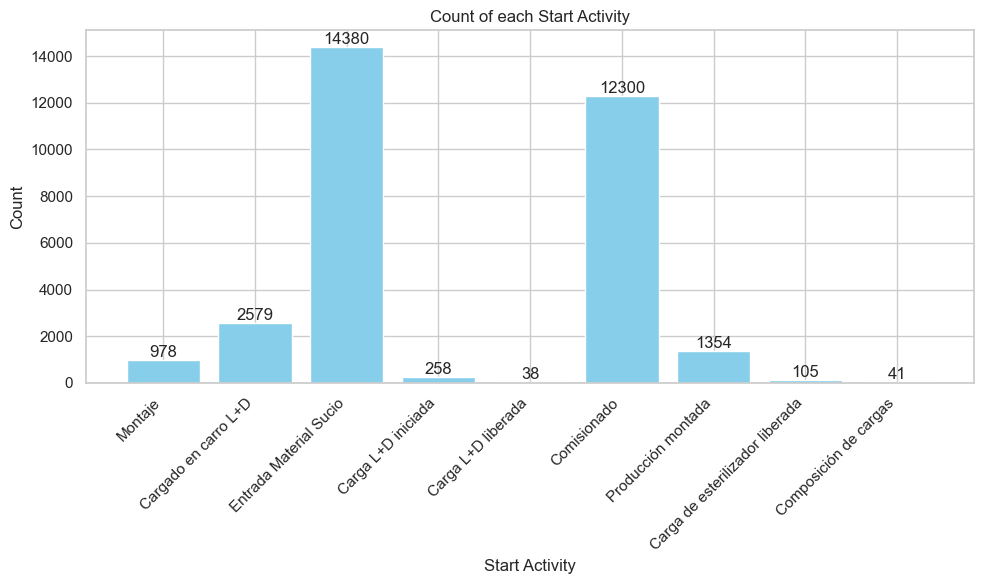

In [151]:
plt.figure(figsize=(10, 6))
bars = plt.bar(dfStart['Activity'], dfStart['Count'], color='skyblue')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, '%d' % int(height), ha='center', va='bottom')
plt.xlabel('Start Activity')
plt.ylabel('Count')
plt.title('Count of each Start Activity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [152]:
dfEnd = pd.DataFrame(list(pm4py.get_end_activities(event_log).items()), columns=['Activity', 'Count'])
dfEnd.head()

,Activity,Count
0,Montaje,89
1,Cargado en carro L+D,91
2,Producción montada,39
3,Carga L+D liberada,3610
4,Entrada Material Sucio,1106


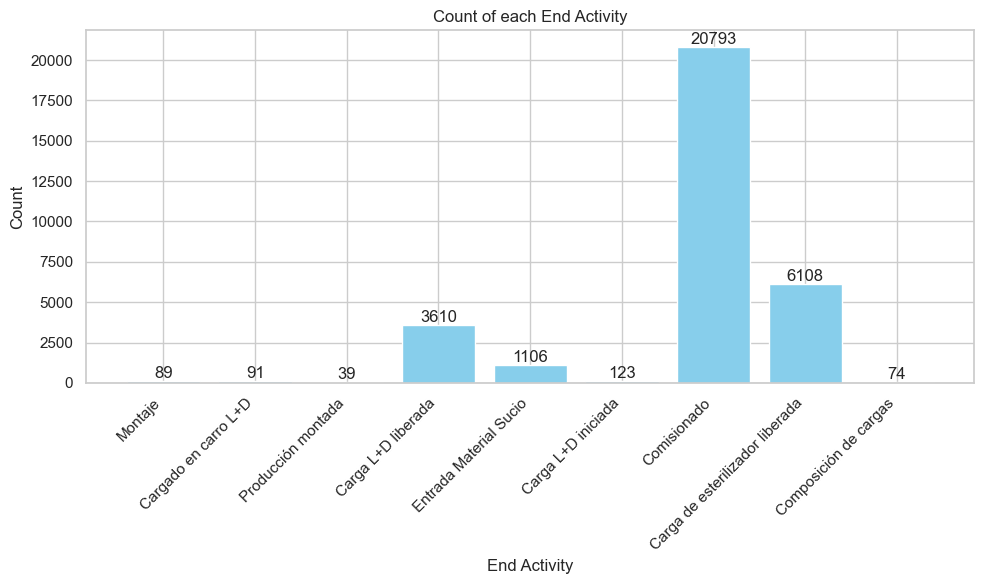

In [153]:
plt.figure(figsize=(10, 6))
bars = plt.bar(dfEnd['Activity'], dfEnd['Count'], color='skyblue')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, '%d' % int(height), ha='center', va='bottom')
plt.xlabel('End Activity')
plt.ylabel('Count')
plt.title('Count of each End Activity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [154]:
arrival_rate = stats.get_case_arrival_average(event_log) 
print("Average arrival rate in minutes:", arrival_rate / 60)

Average arrival rate in minutes: 4.027191558441559


In [155]:
median_case_duration = case_statistics.get_median_case_duration(event_log) 
print ('median_case_duration in minutes:', median_case_duration / 60)

median_case_duration in minutes: 94.0


In [156]:
variant_statistics = case_statistics.get_variant_statistics(event_log) 
variant_statistics

[{'variant': ('Comisionado',), 'count': 12297},
 {'variant': ('Entrada Material Sucio',
   'Cargado en carro L+D',
   'Carga L+D iniciada',
   'Carga L+D liberada',
   'Montaje',
   'Producción montada',
   'Composición de cargas',
   'Carga de esterilizador liberada'),
  'count': 2764},
 {'variant': ('Entrada Material Sucio',
   'Cargado en carro L+D',
   'Carga L+D iniciada',
   'Carga L+D liberada',
   'Montaje',
   'Producción montada',
   'Composición de cargas',
   'Carga de esterilizador liberada',
   'Comisionado'),
  'count': 2688},
 {'variant': ('Entrada Material Sucio',
   'Cargado en carro L+D',
   'Carga L+D iniciada',
   'Carga L+D liberada'),
  'count': 2064},
 {'variant': ('Entrada Material Sucio',), 'count': 1105},
 {'variant': ('Entrada Material Sucio',
   'Cargado en carro L+D',
   'Carga L+D iniciada',
   'Carga L+D liberada',
   'Producción montada',
   'Montaje',
   'Composición de cargas',
   'Carga de esterilizador liberada',
   'Comisionado'),
  'count': 912},


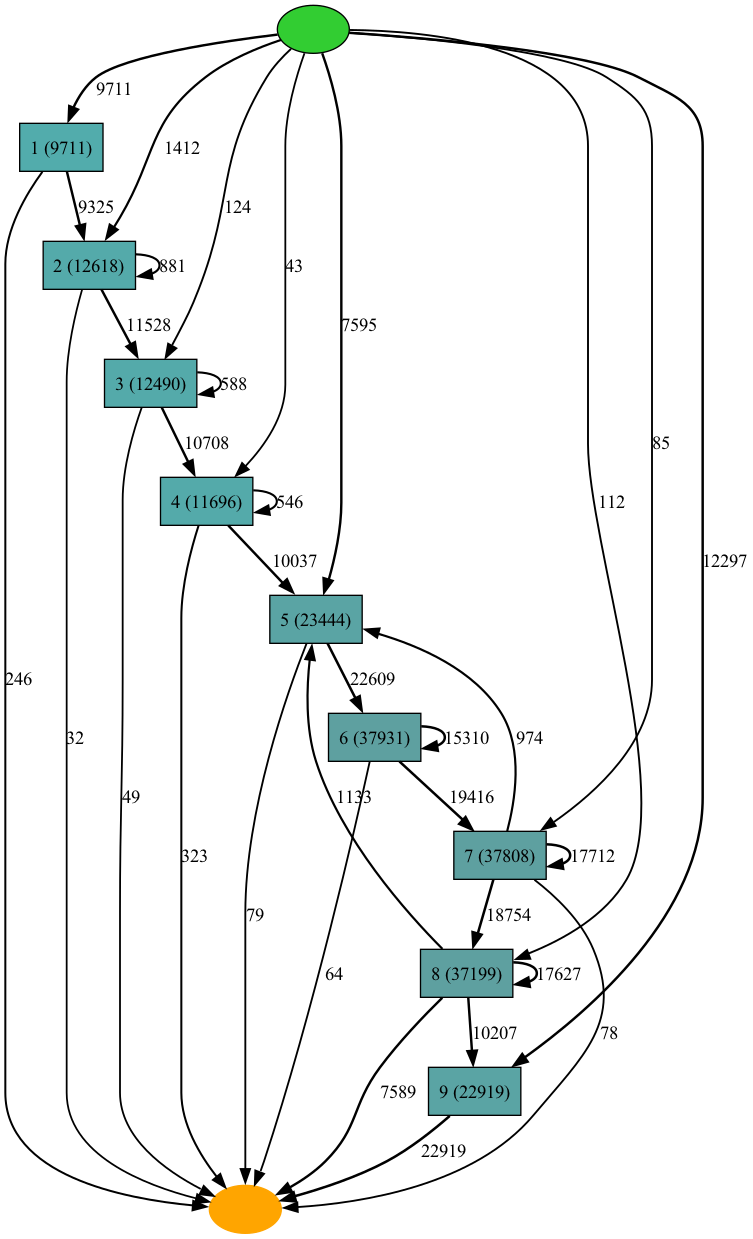

In [133]:
heu_net = pm4py.discover_heuristics_net(event_log, dependency_threshold=0.0)
pm4py.view_heuristics_net(heu_net)

### 2- Process discovery over the data with filter on the frequency of the trace

In [158]:
trace_frequency = Counter()
for trace in event_log:
    trace_id = tuple(event["concept:name"] for event in trace)
    trace_frequency[trace_id] += 1

In [159]:
min_frequency = 10  

filtered_event_log = EventLog()
for trace in event_log:
    trace_id = tuple(event["concept:name"] for event in trace)
    if trace_frequency[trace_id] >= min_frequency:
        filtered_event_log.append(trace)


In [160]:
len(pm4py.get_variants_as_tuples(filtered_event_log))

156

In [161]:
median_case_duration = case_statistics.get_median_case_duration(filtered_event_log) 
print ('median_case_duration in minutes:', median_case_duration / 60)

median_case_duration in minutes: 63.0


In [162]:
pm4py.get_start_activities(filtered_event_log)

{'Montaje': 473,
 'Cargado en carro L+D': 1827,
 'Entrada Material Sucio': 12670,
 'Carga L+D iniciada': 146,
 'Comisionado': 12297,
 'Producción montada': 502,
 'Carga de esterilizador liberada': 65,
 'Carga L+D liberada': 18,
 'Composición de cargas': 11}

In [163]:
pm4py.get_end_activities(filtered_event_log)

{'Montaje': 61,
 'Cargado en carro L+D': 73,
 'Producción montada': 12,
 'Carga L+D liberada': 3244,
 'Entrada Material Sucio': 1105,
 'Carga L+D iniciada': 110,
 'Comisionado': 18532,
 'Carga de esterilizador liberada': 4829,
 'Composición de cargas': 43}

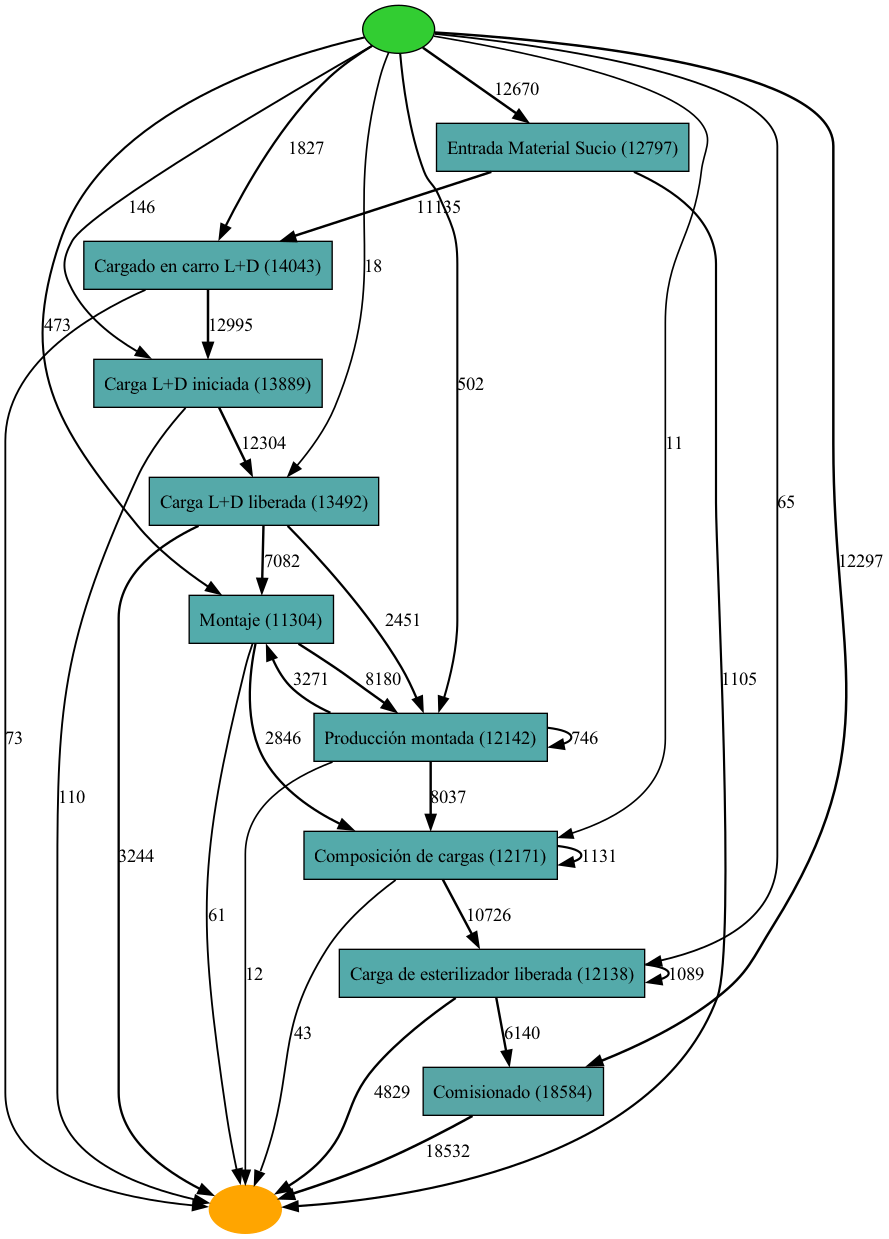

In [164]:
heu_net = pm4py.discover_heuristics_net(filtered_event_log, dependency_threshold=0.9)
pm4py.view_heuristics_net(heu_net)

## Statistics about the process flow

In [165]:
filtered_df = pm4py.convert_to_dataframe(filtered_event_log)
filtered_df.head()

,concept:name,e.Nombre,e.KitID,resource,time:timestamp,e.`Código`,e.NS,@@index,case:concept:name
0,Montaje,Pinza Duckling Right 45,012047 L2901-0,BM,2022-03-02 21:10:00+00:00,012047 L2901,0,12490,012047 L2901-0-CN27313
1,Montaje,Pinza Duckling Right 45,012047 L2901-0,EH,2022-03-08 15:15:00+00:00,012047 L2901,0,12488,012047 L2901-0-CN28716
2,Montaje,Pinza Duckling Right 45,012047 L2901-0,SP,2022-03-22 21:16:00+00:00,012047 L2901,0,12482,012047 L2901-0-CN32695
3,Cargado en carro L+D,Pinza Duckling Right 45,012047 L2901-0,AV,2022-03-30 15:01:00+00:00,012047 L2901,0,6288,012047 L2901-0-CN34935
4,Montaje,Pinza Duckling Right 45,012047 L2901-0,ER,2022-01-18 19:11:00+00:00,012047 L2901,0,168540,012047 L2901-0-CN6844


In [166]:
segments = []
df = filtered_df.sort_values(['case:concept:name', 'time:timestamp', 'concept:name'])

result = pd.concat([df, df.shift(-1)], axis=1)
result.columns = [str(i) + str(k // (len(df.columns))) for k, i in enumerate(result.columns)]
result = result[result['case:concept:name0'] == result['case:concept:name1']]

result['segment_name'] = result['concept:name0'] + ' - ' + result['concept:name1']
result.drop(['concept:name0', 'case:concept:name1', 'concept:name1'], axis=1, inplace=True)
result.columns = ['start_' + i.split('0')[0] if '0' in i else ('end_' + i.split('1')[0] if '1' in i else i) for i in result.columns]

segments = result['segment_name'].unique()
result.head()

,start_e.Nombre,start_e.KitID,start_resource,start_time:timestamp,start_e.`Código`,start_e.NS,start_@@index,start_case:concept:name,end_e.Nombre,end_e.KitID,end_resource,end_time:timestamp,end_e.`Código`,end_e.NS,end_@@index,segment_name
4,Pinza Duckling Right 45,012047 L2901-0,ER,2022-01-18 19:11:00+00:00,012047 L2901,0,168540,012047 L2901-0-CN6844,Pinza Duckling Right 45,012047 L2901-0,ER,2022-01-18 19:11:00+00:00,012047 L2901,0.0,168541.0,Montaje - Producción montada
6,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,ER,2022-01-28 13:10:00+00:00,CONT-CCEE.ALE,1,60461,CONT-CCEE.ALE-1-CN11678,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,ER,2022-01-28 13:18:00+00:00,CONT-CCEE.ALE,1.0,60459.0,Entrada Material Sucio - Cargado en carro L+D
7,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,ER,2022-01-28 13:18:00+00:00,CONT-CCEE.ALE,1,60459,CONT-CCEE.ALE-1-CN11678,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,MMF,2022-01-28 13:34:00+00:00,CONT-CCEE.ALE,1.0,60462.0,Cargado en carro L+D - Carga L+D iniciada
8,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,MMF,2022-01-28 13:34:00+00:00,CONT-CCEE.ALE,1,60462,CONT-CCEE.ALE-1-CN11678,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,MCE,2022-01-28 14:39:00+00:00,CONT-CCEE.ALE,1.0,60460.0,Carga L+D iniciada - Carga L+D liberada
10,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,ER,2022-01-05 13:26:00+00:00,CONT-CCEE.ALE,1,78606,CONT-CCEE.ALE-1-CN1411,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,ER,2022-01-05 13:29:00+00:00,CONT-CCEE.ALE,1.0,78605.0,Entrada Material Sucio - Cargado en carro L+D


### 1- Over all statistics

In [167]:
result['durationMinutes'] = (result['end_time:timestamp'] - result['start_time:timestamp']).dt.total_seconds() / 60 

In [168]:
Q1 = result.groupby('segment_name')['durationMinutes'].quantile(0.25)
Q3 = result.groupby('segment_name')['durationMinutes'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

result_filtered = result[~result.apply(lambda x: (x['durationMinutes'] < lower_bound[x['segment_name']]) or 
                                              (x['durationMinutes'] > upper_bound[x['segment_name']]), axis=1)]

grouped = result_filtered.groupby('segment_name')['durationMinutes'].describe()
grouped.head()

,count,mean,std,min,25%,50%,75%,max
segment_name,,,,,,,,
Carga L+D iniciada - Carga L+D iniciada,273.0,19.886447,23.111739,0.0,3.0,12.0,29.0,82.0
Carga L+D iniciada - Carga L+D liberada,10821.0,68.354588,8.385879,46.0,63.0,68.0,74.0,92.0
Carga L+D iniciada - Carga de esterilizador liberada,51.0,11.568627,10.286408,0.0,4.0,8.0,18.0,38.0
Carga L+D iniciada - Cargado en carro L+D,981.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Carga L+D iniciada - Comisionado,8.0,42.000000,0.000000,42.0,42.0,42.0,42.0,42.0


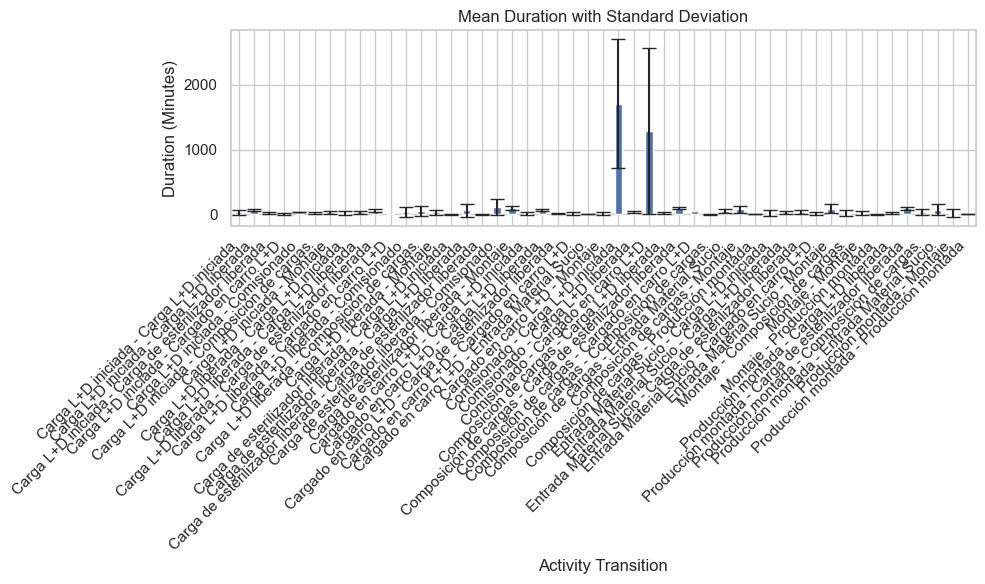

In [169]:
result['durationMinutes'] = (result['end_time:timestamp'] - result['start_time:timestamp']).dt.total_seconds() / 60 
grouped = result.groupby(['segment_name'])['durationMinutes'].describe()

plt.figure(figsize=(10, 6))
grouped['mean'].plot(kind='bar', yerr=grouped['std'], capsize=5)
plt.xlabel('Activity Transition')
plt.ylabel('Duration (Minutes)')
plt.title('Mean Duration with Standard Deviation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [170]:
result.head()

,start_e.Nombre,start_e.KitID,start_resource,start_time:timestamp,start_e.`Código`,start_e.NS,start_@@index,start_case:concept:name,end_e.Nombre,end_e.KitID,end_resource,end_time:timestamp,end_e.`Código`,end_e.NS,end_@@index,segment_name,durationMinutes
4,Pinza Duckling Right 45,012047 L2901-0,ER,2022-01-18 19:11:00+00:00,012047 L2901,0,168540,012047 L2901-0-CN6844,Pinza Duckling Right 45,012047 L2901-0,ER,2022-01-18 19:11:00+00:00,012047 L2901,0.0,168541.0,Montaje - Producción montada,0.0
6,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,ER,2022-01-28 13:10:00+00:00,CONT-CCEE.ALE,1,60461,CONT-CCEE.ALE-1-CN11678,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,ER,2022-01-28 13:18:00+00:00,CONT-CCEE.ALE,1.0,60459.0,Entrada Material Sucio - Cargado en carro L+D,8.0
7,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,ER,2022-01-28 13:18:00+00:00,CONT-CCEE.ALE,1,60459,CONT-CCEE.ALE-1-CN11678,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,MMF,2022-01-28 13:34:00+00:00,CONT-CCEE.ALE,1.0,60462.0,Cargado en carro L+D - Carga L+D iniciada,16.0
8,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,MMF,2022-01-28 13:34:00+00:00,CONT-CCEE.ALE,1,60462,CONT-CCEE.ALE-1-CN11678,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,MCE,2022-01-28 14:39:00+00:00,CONT-CCEE.ALE,1.0,60460.0,Carga L+D iniciada - Carga L+D liberada,65.0
10,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,ER,2022-01-05 13:26:00+00:00,CONT-CCEE.ALE,1,78606,CONT-CCEE.ALE-1-CN1411,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,ER,2022-01-05 13:29:00+00:00,CONT-CCEE.ALE,1.0,78605.0,Entrada Material Sucio - Cargado en carro L+D,3.0


In [171]:
grouped.head()

,count,mean,std,min,25%,50%,75%,max
segment_name,,,,,,,,
Carga L+D iniciada - Carga L+D iniciada,295.0,30.318644,43.947327,0.0,3.0,13.0,37.0,195.0
Carga L+D iniciada - Carga L+D liberada,11918.0,69.765229,14.021559,1.0,63.0,69.0,75.0,181.0
Carga L+D iniciada - Carga de esterilizador liberada,56.0,15.464286,15.999959,0.0,4.0,9.0,21.0,65.0
Carga L+D iniciada - Cargado en carro L+D,1175.0,4.519149,15.873524,0.0,0.0,0.0,0.0,133.0
Carga L+D iniciada - Comisionado,10.0,43.000000,2.108185,42.0,42.0,42.0,42.0,47.0


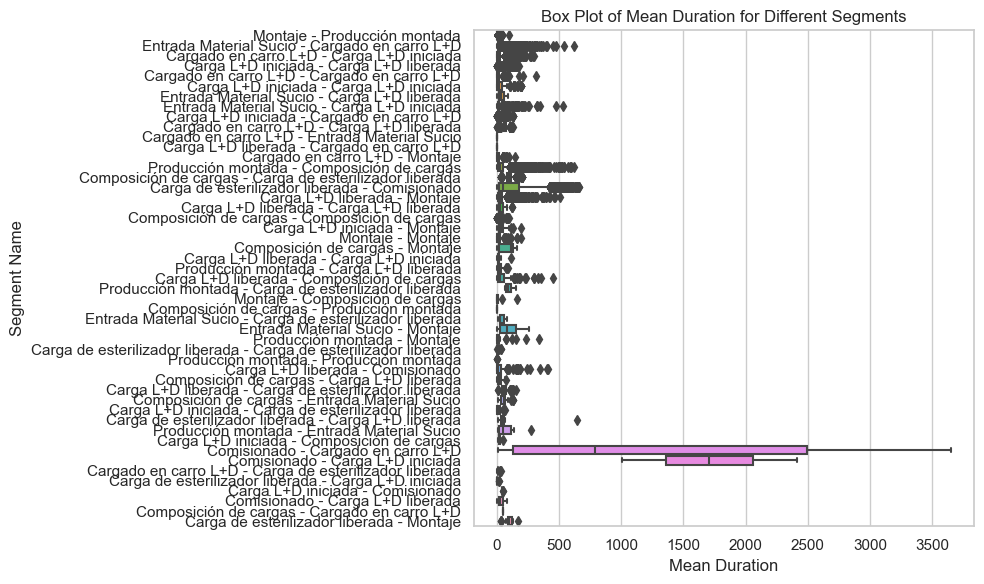

In [172]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.boxplot(x=result['durationMinutes'], y=result['segment_name'], showfliers=True)
plt.xlabel('Mean Duration')
plt.ylabel('Segment Name')
plt.title('Box Plot of Mean Duration for Different Segments')
plt.tight_layout()
plt.show()

### 2- add frequency filter, to filter incidences less that 100 time

In [173]:
freq = grouped[grouped['count'] > 100]
freq.head()

,count,mean,std,min,25%,50%,75%,max
segment_name,,,,,,,,
Carga L+D iniciada - Carga L+D iniciada,295.0,30.318644,43.947327,0.0,3.00,13.0,37.0,195.0
Carga L+D iniciada - Carga L+D liberada,11918.0,69.765229,14.021559,1.0,63.00,69.0,75.0,181.0
Carga L+D iniciada - Cargado en carro L+D,1175.0,4.519149,15.873524,0.0,0.00,0.0,0.0,133.0
Carga L+D iniciada - Montaje,318.0,34.550314,25.217708,0.0,13.25,32.0,49.0,194.0
Carga L+D liberada - Carga L+D liberada,256.0,32.937500,23.326077,1.0,13.00,26.0,49.0,120.0


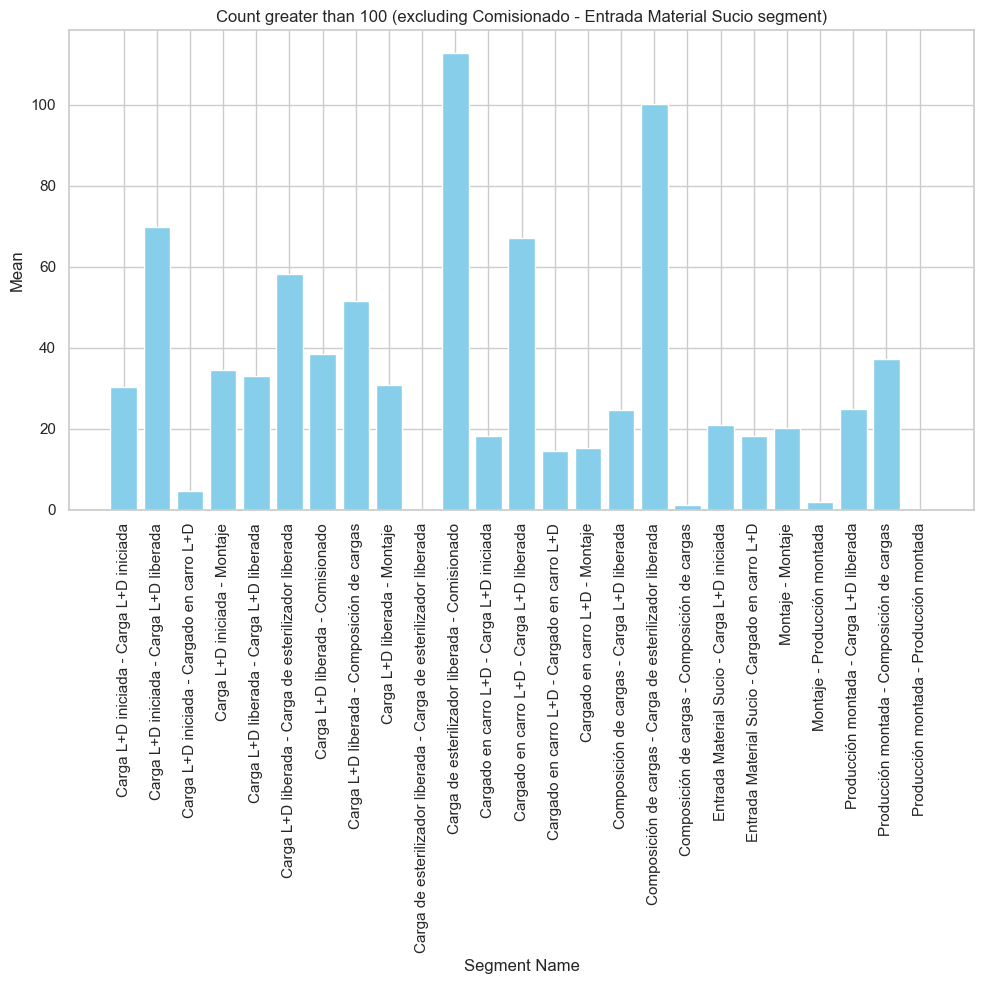

In [174]:
segment_to_exclude = 'Comisionado - Entrada Material Sucio'

filtered_df_excluded = freq[freq.index != segment_to_exclude]

plt.figure(figsize=(10, 10))
plt.bar(filtered_df_excluded.index, filtered_df_excluded['mean'], color='skyblue')
plt.xlabel('Segment Name')
plt.ylabel('Mean')
plt.title('Count greater than 100 (excluding Comisionado - Entrada Material Sucio segment)')
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()

### 3- Plot the data including a specified segments

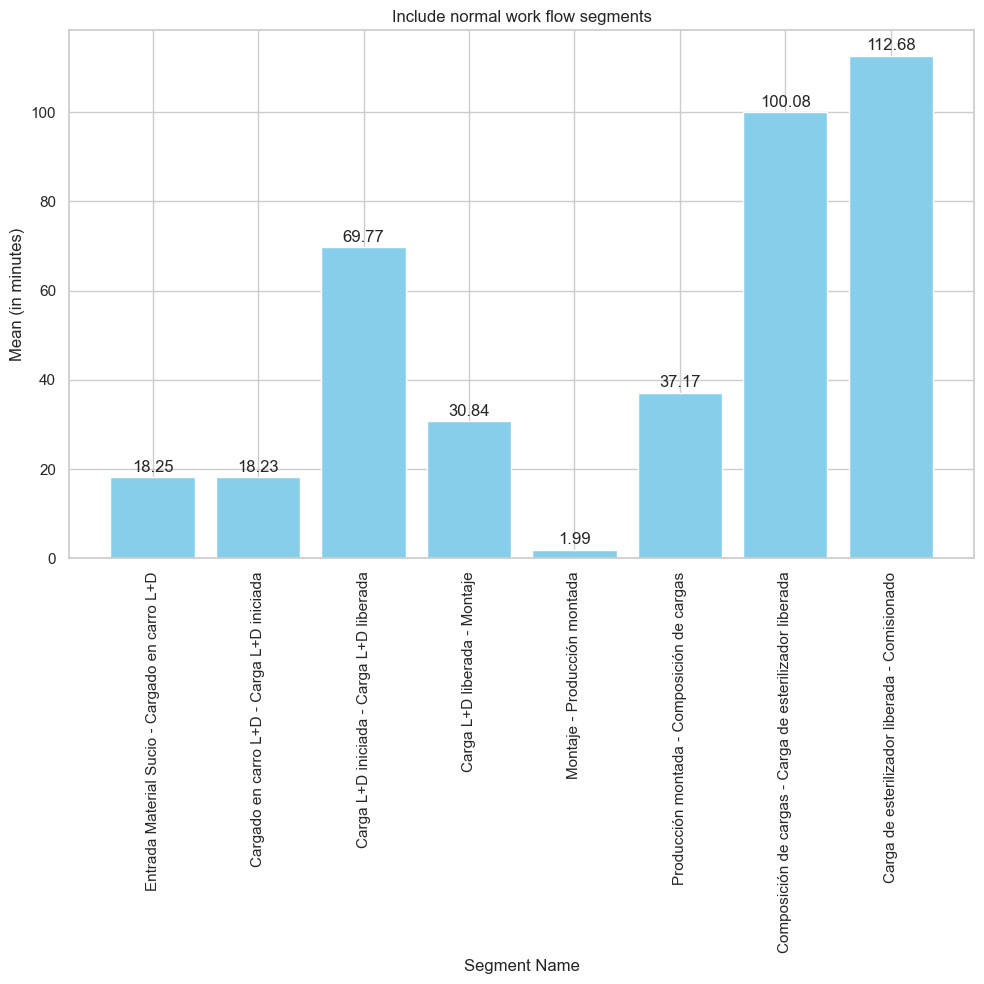

In [175]:
segments_work_flow = ['Entrada Material Sucio - Cargado en carro L+D',
                        'Cargado en carro L+D - Carga L+D iniciada',
                         'Carga L+D iniciada - Carga L+D liberada',
                          'Carga L+D liberada - Montaje',
                           'Montaje - Producción montada',
                            'Producción montada - Composición de cargas',
                             'Composición de cargas - Carga de esterilizador liberada',
                              'Carga de esterilizador liberada - Comisionado']

filtered_df_included = grouped[grouped.index.isin(segments_work_flow)]
filtered_df_included = filtered_df_included.loc[segments_work_flow]

plt.figure(figsize=(10, 10))
bars = plt.bar(filtered_df_included.index, filtered_df_included['mean'], color='skyblue')

for bar, mean in zip(bars, filtered_df_included['mean']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{mean:.2f}', ha='center', va='bottom')

plt.xlabel('Segment Name')
plt.ylabel('Mean (in minutes)')
plt.title('Include normal work flow segments')
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()

In [176]:
filtered_df_included.head(10)

,count,mean,std,min,25%,50%,75%,max
segment_name,,,,,,,,
Entrada Material Sucio - Cargado en carro L+D,10682.0,18.247519,24.567720,1.0,8.0,13.0,21.0,622.0
Cargado en carro L+D - Carga L+D iniciada,12436.0,18.227565,23.052560,1.0,3.0,10.0,26.0,295.0
Carga L+D iniciada - Carga L+D liberada,11918.0,69.765229,14.021559,1.0,63.0,69.0,75.0,181.0
Carga L+D liberada - Montaje,9540.0,30.842243,35.169998,0.0,10.0,21.0,39.0,509.0
Montaje - Producción montada,11087.0,1.988275,4.096421,0.0,0.0,0.0,2.0,98.0
Producción montada - Composición de cargas,10879.0,37.173453,45.821654,1.0,10.0,23.0,47.0,620.0
Composición de cargas - Carga de esterilizador liberada,10712.0,100.084111,21.269128,29.0,84.0,100.0,113.0,201.0
Carga de esterilizador liberada - Comisionado,6140.0,112.682573,128.807603,0.0,17.0,51.0,178.0,656.0


In [177]:
total_row = filtered_df_included.sum(axis=0)
total_row['segment_name'] = 'Total'

df_with_total = filtered_df_included.append(total_row, ignore_index=True)
df_with_total.head(10)

,count,mean,std,min,25%,50%,75%,max,segment_name
0,10682.0,18.247519,24.567720,1.0,8.0,13.0,21.0,622.0,NaN
1,12436.0,18.227565,23.052560,1.0,3.0,10.0,26.0,295.0,NaN
2,11918.0,69.765229,14.021559,1.0,63.0,69.0,75.0,181.0,NaN
3,9540.0,30.842243,35.169998,0.0,10.0,21.0,39.0,509.0,NaN
4,11087.0,1.988275,4.096421,0.0,0.0,0.0,2.0,98.0,NaN
5,10879.0,37.173453,45.821654,1.0,10.0,23.0,47.0,620.0,NaN
6,10712.0,100.084111,21.269128,29.0,84.0,100.0,113.0,201.0,NaN
7,6140.0,112.682573,128.807603,0.0,17.0,51.0,178.0,656.0,NaN
8,83394.0,389.010969,296.806642,33.0,195.0,287.0,501.0,3182.0,Total


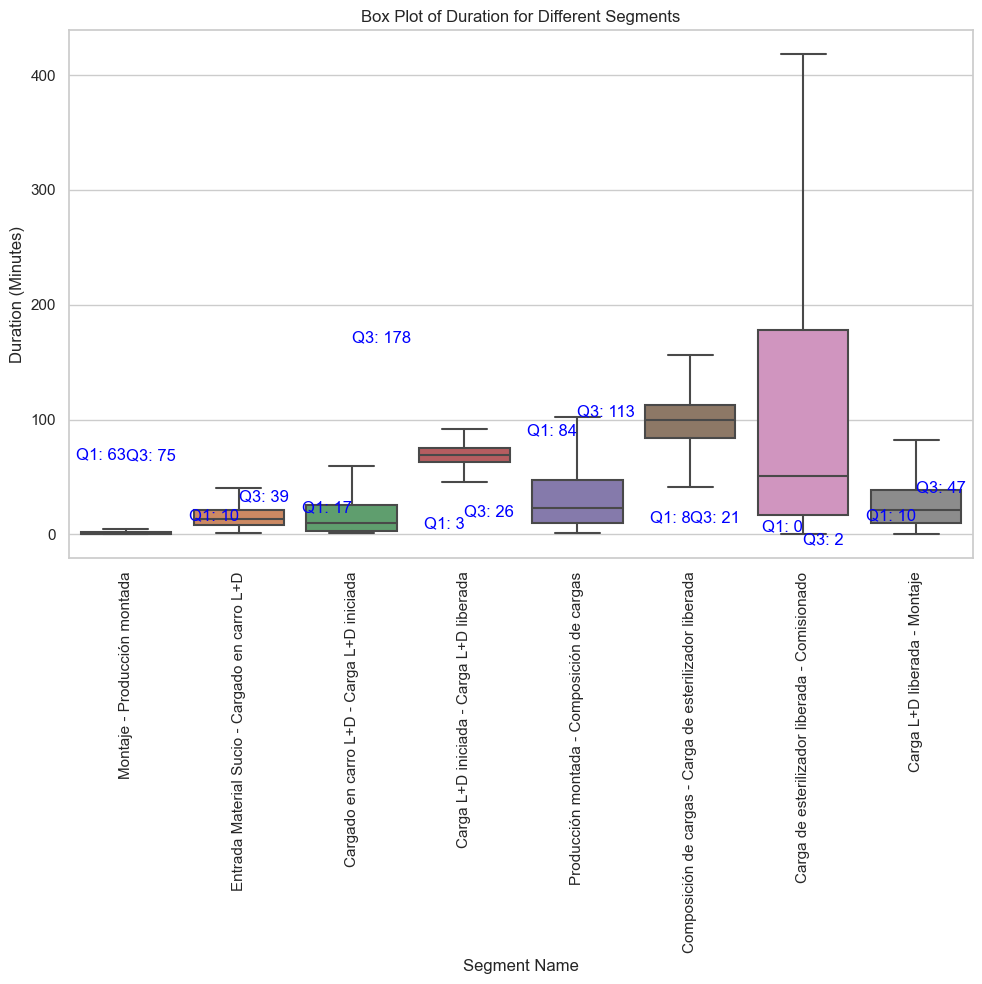

In [178]:
filtered_data = result[result['segment_name'].isin(segments_work_flow)]

grouped_data = filtered_data.groupby('segment_name')['durationMinutes']
statistics = grouped_data.describe(percentiles=[.25, .75])[['std', '25%', '75%']].reset_index()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 10))
sns.boxplot(x='segment_name', y='durationMinutes', data=filtered_data, showfliers= False)
plt.xlabel('Segment Name')
plt.ylabel('Duration (Minutes)')
plt.title('Box Plot of Duration for Different Segments')

for i in range(len(statistics)):
    segment_name = statistics.loc[i, 'segment_name']
    q1 = statistics.loc[i, '25%']
    q3 = statistics.loc[i, '75%']
    plt.text(i, q1, f'Q1: {q1:.0f}', ha='right', va='bottom', color='blue')
    plt.text(i, q3, f'Q3: {q3:.0f}', ha='left', va='top', color='blue')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [179]:
filtered_data.head()

,start_e.Nombre,start_e.KitID,start_resource,start_time:timestamp,start_e.`Código`,start_e.NS,start_@@index,start_case:concept:name,end_e.Nombre,end_e.KitID,end_resource,end_time:timestamp,end_e.`Código`,end_e.NS,end_@@index,segment_name,durationMinutes
4,Pinza Duckling Right 45,012047 L2901-0,ER,2022-01-18 19:11:00+00:00,012047 L2901,0,168540,012047 L2901-0-CN6844,Pinza Duckling Right 45,012047 L2901-0,ER,2022-01-18 19:11:00+00:00,012047 L2901,0.0,168541.0,Montaje - Producción montada,0.0
6,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,ER,2022-01-28 13:10:00+00:00,CONT-CCEE.ALE,1,60461,CONT-CCEE.ALE-1-CN11678,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,ER,2022-01-28 13:18:00+00:00,CONT-CCEE.ALE,1.0,60459.0,Entrada Material Sucio - Cargado en carro L+D,8.0
7,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,ER,2022-01-28 13:18:00+00:00,CONT-CCEE.ALE,1,60459,CONT-CCEE.ALE-1-CN11678,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,MMF,2022-01-28 13:34:00+00:00,CONT-CCEE.ALE,1.0,60462.0,Cargado en carro L+D - Carga L+D iniciada,16.0
8,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,MMF,2022-01-28 13:34:00+00:00,CONT-CCEE.ALE,1,60462,CONT-CCEE.ALE-1-CN11678,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,MCE,2022-01-28 14:39:00+00:00,CONT-CCEE.ALE,1.0,60460.0,Carga L+D iniciada - Carga L+D liberada,65.0
10,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,ER,2022-01-05 13:26:00+00:00,CONT-CCEE.ALE,1,78606,CONT-CCEE.ALE-1-CN1411,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,ER,2022-01-05 13:29:00+00:00,CONT-CCEE.ALE,1.0,78605.0,Entrada Material Sucio - Cargado en carro L+D,3.0


### 4- Plot the data including tasks skipping one in between

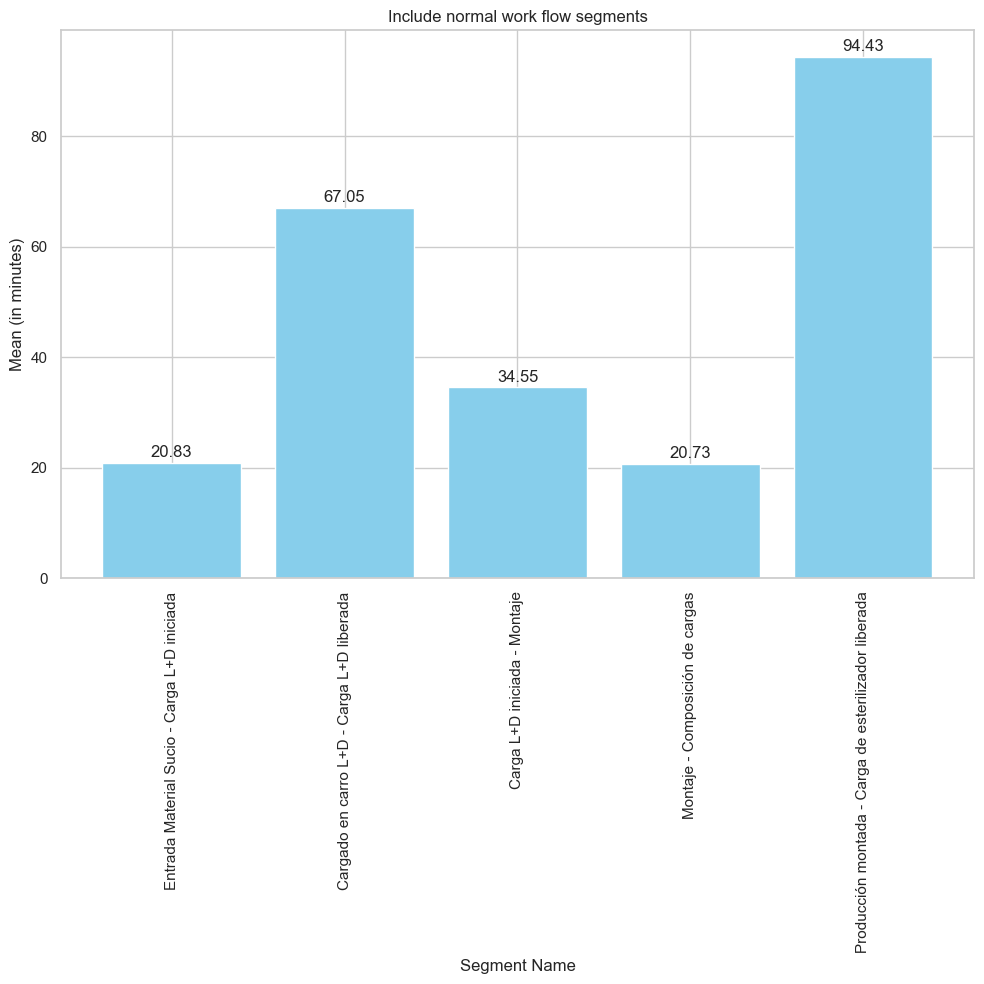

In [180]:
segments_to_include = ['Entrada Material Sucio - Carga L+D iniciada',
                        'Cargado en carro L+D - Carga L+D liberada',
                         'Carga L+D iniciada - Montaje',
                           'Montaje - Composición de cargas',
                            'Producción montada - Carga de esterilizador liberada']

filtered_df_included = grouped[grouped.index.isin(segments_to_include)]
filtered_df_included = filtered_df_included.loc[segments_to_include]

plt.figure(figsize=(10, 10))
bars = plt.bar(filtered_df_included.index, filtered_df_included['mean'], color='skyblue')

for bar, mean in zip(bars, filtered_df_included['mean']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{mean:.2f}', ha='center', va='bottom')

plt.xlabel('Segment Name')
plt.ylabel('Mean (in minutes)')
plt.title('Include normal work flow segments')
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()

In [181]:
filtered_df_included.head()

,count,mean,std,min,25%,50%,75%,max
segment_name,,,,,,,,
Entrada Material Sucio - Carga L+D iniciada,864.0,20.833333,41.629080,1.0,6.00,11.0,19.00,530.0
Cargado en carro L+D - Carga L+D liberada,834.0,67.049161,18.396885,3.0,58.00,68.0,76.00,126.0
Carga L+D iniciada - Montaje,318.0,34.550314,25.217708,0.0,13.25,32.0,49.00,194.0
Montaje - Composición de cargas,11.0,20.727273,48.709529,1.0,2.00,2.0,6.50,164.0
Producción montada - Carga de esterilizador liberada,14.0,94.428571,24.672359,64.0,74.50,90.0,111.25,153.0


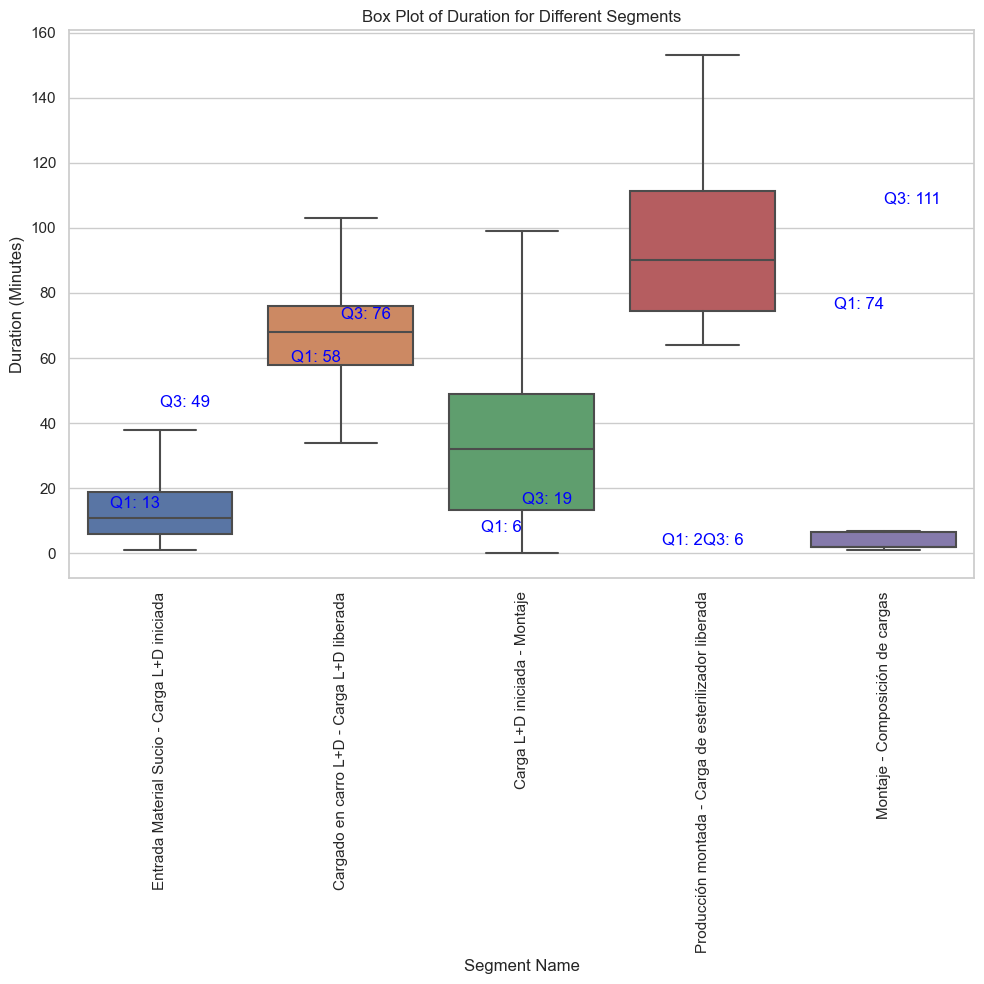

In [182]:
filtered_data = result[result['segment_name'].isin(segments_to_include)]

grouped_data = filtered_data.groupby('segment_name')['durationMinutes']
statistics = grouped_data.describe(percentiles=[.25, .75])[['std', '25%', '75%']].reset_index()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 10))
sns.boxplot(x='segment_name', y='durationMinutes', data=filtered_data, showfliers= False)
plt.xlabel('Segment Name')
plt.ylabel('Duration (Minutes)')
plt.title('Box Plot of Duration for Different Segments')

for i in range(len(statistics)):
    segment_name = statistics.loc[i, 'segment_name']
    q1 = statistics.loc[i, '25%']
    q3 = statistics.loc[i, '75%']
    plt.text(i, q1, f'Q1: {q1:.0f}', ha='right', va='bottom', color='blue')
    plt.text(i, q3, f'Q3: {q3:.0f}', ha='left', va='top', color='blue')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [183]:
statistics.head()

,segment_name,std,25%,75%
0,Carga L+D iniciada - Montaje,25.217708,13.25,49.00
1,Cargado en carro L+D - Carga L+D liberada,18.396885,58.00,76.00
2,Entrada Material Sucio - Carga L+D iniciada,41.629080,6.00,19.00
3,Montaje - Composición de cargas,48.709529,2.00,6.50
4,Producción montada - Carga de esterilizador li...,24.672359,74.50,111.25


### 5- Exclude the normal process flow

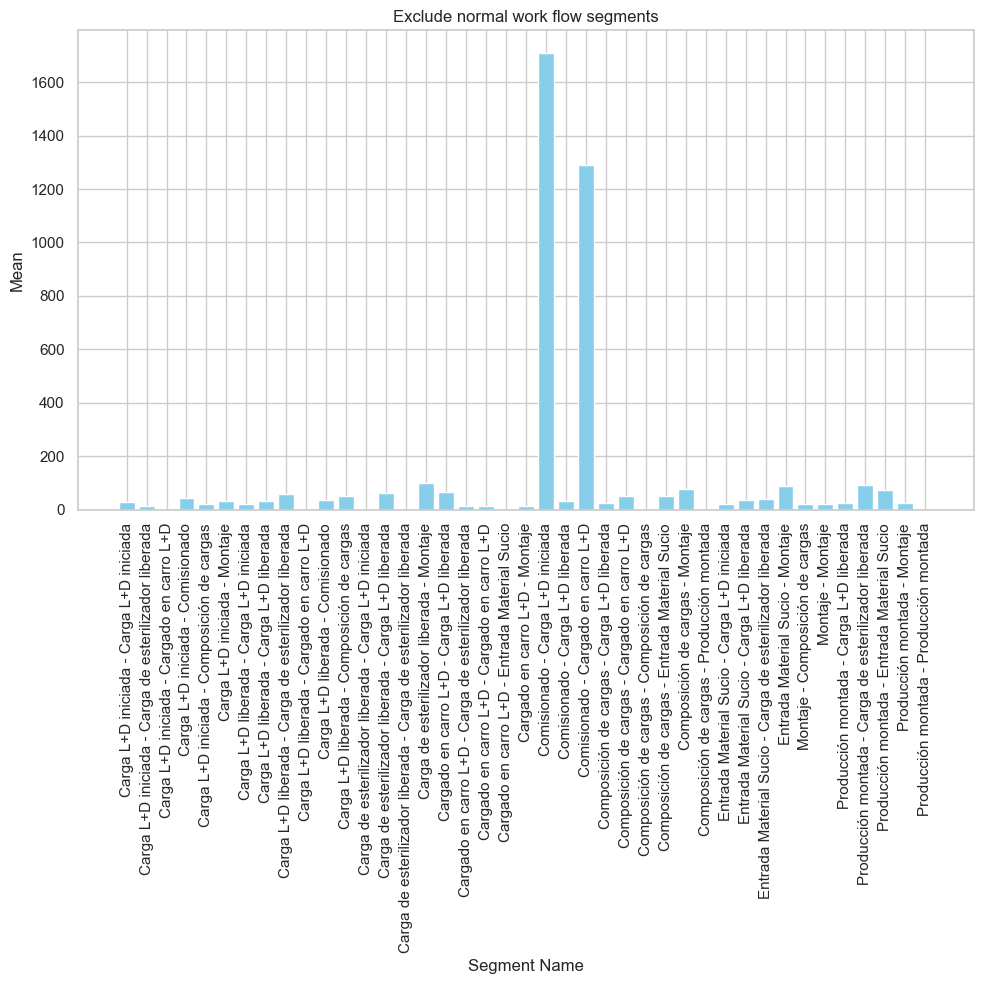

In [184]:
filtered_df_excluded = filtered_df[~filtered_df.index.isin(segments_work_flow)]
filtered_df_excluded = grouped[~grouped.index.isin(segments_work_flow)]

plt.figure(figsize=(10, 10))
plt.bar(filtered_df_excluded.index, filtered_df_excluded['mean'], color='skyblue')
plt.xlabel('Segment Name')
plt.ylabel('Mean')
plt.title('Exclude normal work flow segments')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

In [185]:
filtered_df_excluded.head()

,count,mean,std,min,25%,50%,75%,max
segment_name,,,,,,,,
Carga L+D iniciada - Carga L+D iniciada,295.0,30.318644,43.947327,0.0,3.00,13.0,37.0,195.0
Carga L+D iniciada - Carga de esterilizador liberada,56.0,15.464286,15.999959,0.0,4.00,9.0,21.0,65.0
Carga L+D iniciada - Cargado en carro L+D,1175.0,4.519149,15.873524,0.0,0.00,0.0,0.0,133.0
Carga L+D iniciada - Comisionado,10.0,43.000000,2.108185,42.0,42.00,42.0,42.0,47.0
Carga L+D iniciada - Composición de cargas,10.0,21.900000,11.327940,12.0,12.75,21.0,25.5,49.0


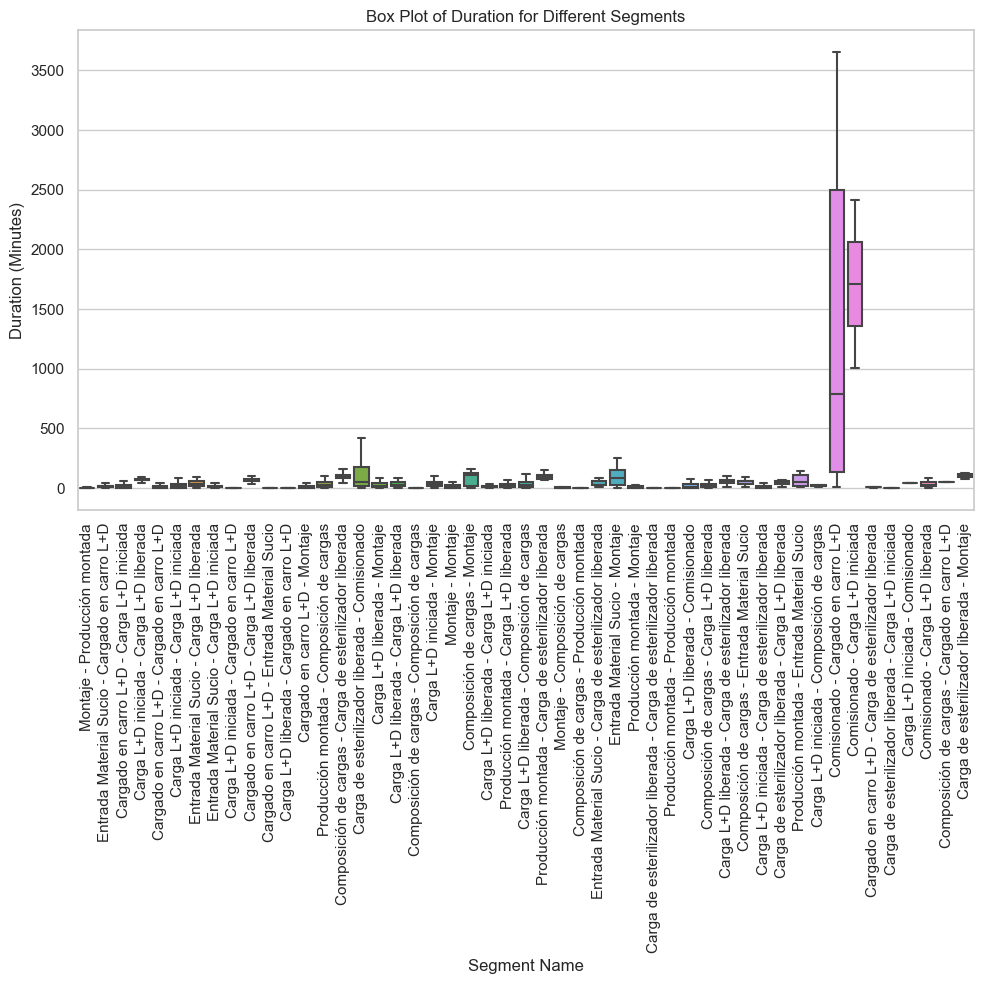

In [186]:
filtered_data = result[~result['segment_name'].isin(filtered_df_excluded)]

grouped_data = filtered_data.groupby('segment_name')['durationMinutes']
statistics = grouped_data.describe(percentiles=[.25, .75])[['std', '25%', '75%']].reset_index()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 10))
sns.boxplot(x='segment_name', y='durationMinutes', data=filtered_data, showfliers= False)
plt.xlabel('Segment Name')
plt.ylabel('Duration (Minutes)')
plt.title('Box Plot of Duration for Different Segments')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [187]:
statistics.head()

,segment_name,std,25%,75%
0,Carga L+D iniciada - Carga L+D iniciada,43.947327,3.0,37.0
1,Carga L+D iniciada - Carga L+D liberada,14.021559,63.0,75.0
2,Carga L+D iniciada - Carga de esterilizador li...,15.999959,4.0,21.0
3,Carga L+D iniciada - Cargado en carro L+D,15.873524,0.0,0.0
4,Carga L+D iniciada - Comisionado,2.108185,42.0,42.0


## Sankey diagram

### 1- For activities related to cases

In [188]:
query = f'''MATCH (r:Run) <- [:HAS_RUN] - (e:Entity)
MATCH (evr1:Event) - [:CORR] -> (r) <- [:CORR] - (evr2:Event)
where not evr1:OnlyKitEvent and not evr2:OnlyKitEvent
match (evr1) - [d:DF] -> (evr2)
with evr1.Activity as er1, evr2.Activity as er2, count(d) as d
RETURN er1, er2, d'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf = pd.DataFrame(records, columns=columns)
sddf.head()

,er1,er2,d
0,Carga L+D iniciada,Carga L+D liberada,18994
1,Cargado en carro L+D,Carga L+D iniciada,19950
2,Producción montada,Composición de cargas,19416
3,Carga L+D liberada,Montaje,10037
4,Montaje,Producción montada,22609


In [189]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf['er1'].tolist() + sddf['er2'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf['er1'].map(lambda x: list(set(sddf['er1'].tolist() + sddf['er2'].tolist())).index(x)),
        target=sddf['er2'].map(lambda x: list(set(sddf['er1'].tolist() + sddf['er2'].tolist())).index(x)),
        value=sddf['d']
    ),
    orientation='h'
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()


### 2- For activities not related to any case / Not valid anymore

In [190]:
query = f'''MATCH (e:Run)
MATCH (eve1:Event) - [:CORR] -> (e) <- [:CORR] - (eve2:Event)
where not eve1:OnlyKitEvent and not eve2:OnlyKitEvent
match (eve1) - [d:DF] -> (eve2)
with eve1.Activity as ev1, eve2.Activity as ev2, count(d) as c
RETURN ev1, ev2, c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf2 = pd.DataFrame(records, columns=columns)
sddf2.head()

,ev1,ev2,c
0,Carga L+D iniciada,Carga L+D liberada,18994
1,Cargado en carro L+D,Carga L+D iniciada,19950
2,Producción montada,Composición de cargas,19416
3,Carga L+D liberada,Montaje,10037
4,Montaje,Producción montada,22609


In [191]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf2['ev1'].tolist() + sddf2['ev2'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf2['ev1'].map(lambda x: list(set(sddf2['ev1'].tolist() + sddf2['ev2'].tolist())).index(x)),
        target=sddf2['ev2'].map(lambda x: list(set(sddf2['ev1'].tolist() + sddf2['ev2'].tolist())).index(x)),
        value=sddf2['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

### 3- For all events

In [192]:
query = f'''MATCH  ( e1 : Event ) -[df:DF]-> ( e2 : Event )
with  e1.Activity as e1a, e2.Activity as e2a, count(df) as c
where c > 50
return e1a, e2a, c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf3 = pd.DataFrame(records, columns=columns)
sddf3.head()

,e1a,e2a,c
0,Entrada Material Sucio,Cargado en carro L+D,11845
1,Entrada Material Sucio,Entrada Material Sucio,968
2,Entrada Material Sucio,Carga L+D iniciada,62
3,Entrada Material Sucio,Montaje,73
4,Entrada Material Sucio,Carga L+D liberada,83


In [193]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf3['e1a'].tolist() + sddf3['e2a'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf3['e1a'].map(lambda x: list(set(sddf3['e1a'].tolist() + sddf3['e2a'].tolist())).index(x)),
        target=sddf3['e2a'].map(lambda x: list(set(sddf3['e1a'].tolist() + sddf3['e2a'].tolist())).index(x)),
        value=sddf3['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

### 4- Between Cases

In [194]:
query = f'''MATCH p=()-[r:DF_CYCLE]->() 
return distinct (r.EndActivity) as end, r.StartActivity as start, count(r) as c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf4 = pd.DataFrame(records, columns=columns)
sddf4.head()

,end,start,c
0,Entrada Material Sucio,Entrada Material Sucio,968
1,Entrada Material Sucio,Cargado en carro L+D,69
2,Entrada Material Sucio,Montaje,8
3,Entrada Material Sucio,Carga L+D iniciada,2
4,Cargado en carro L+D,Entrada Material Sucio,83


In [195]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf4['end'].tolist() + sddf4['start'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf4['end'].map(lambda x: list(set(sddf4['end'].tolist() + sddf4['start'].tolist())).index(x)),
        target=sddf4['start'].map(lambda x: list(set(sddf4['end'].tolist() + sddf4['start'].tolist())).index(x)),
        value=sddf4['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

### 5- Within cases

In [196]:
query = f'''MATCH p=(e1: Event)-[r:DF_CASE]->(e2: Event)
with  e1.Activity as e1a, e2.Activity as e2a, count(r) as c
where c > 50
return e1a, e2a, c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf5 = pd.DataFrame(records, columns=columns)
sddf5.head()

,e1a,e2a,c
0,Entrada Material Sucio,Cargado en carro L+D,11776
1,Entrada Material Sucio,Carga L+D iniciada,60
2,Entrada Material Sucio,Montaje,65
3,Entrada Material Sucio,Carga L+D liberada,83
4,Cargado en carro L+D,Carga L+D iniciada,14601


In [197]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf5['e1a'].tolist() + sddf5['e2a'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf5['e1a'].map(lambda x: list(set(sddf5['e1a'].tolist() + sddf5['e2a'].tolist())).index(x)),
        target=sddf5['e2a'].map(lambda x: list(set(sddf5['e1a'].tolist() + sddf5['e2a'].tolist())).index(x)),
        value=sddf5['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

### 6- For Cases starting from Entrada only

In [198]:
query = f'''MATCH p=(e1: Event)-[r:DF_CYCLE {{StartActivity: 'Entrada Material Sucio'}}]->(e2: Event) 
WITH collect(r.NextCaseID) AS cases_from_entrada
MATCH p=(e1: Event)-[r:DF_CASE]->(e2: Event)
where r.CaseID in cases_from_entrada
with  e1.Activity as e1a, e2.Activity as e2a, count(r) as c
return e1a, e2a, c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf4 = pd.DataFrame(records, columns=columns)
sddf4.head()

,e1a,e2a,c
0,Entrada Material Sucio,Cargado en carro L+D,10872
1,Entrada Material Sucio,Carga L+D iniciada,57
2,Entrada Material Sucio,Carga de esterilizador liberada,24
3,Entrada Material Sucio,Montaje,62
4,Entrada Material Sucio,Composición de cargas,13


In [199]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf4['e1a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        target=sddf4['e2a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        value=sddf4['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

### 7- For cases starts from Cargado en carro L+D only

In [200]:
query = f'''MATCH p=(e1: Event)-[r:DF_CYCLE {{StartActivity: 'Cargado en carro L+D'}}]->(e2: Event) 
WITH collect(r.NextCaseID) AS cases_from_entrada
MATCH p=(e1: Event)-[r:DF_CASE]->(e2: Event)
where r.CaseID in cases_from_entrada
with  e1.Activity as e1a, e2.Activity as e2a, count(r) as c
return e1a, e2a, c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf4 = pd.DataFrame(records, columns=columns)
sddf4.head()

,e1a,e2a,c
0,Cargado en carro L+D,Carga L+D iniciada,1978
1,Cargado en carro L+D,Cargado en carro L+D,199
2,Cargado en carro L+D,Carga L+D liberada,37
3,Cargado en carro L+D,Montaje,39
4,Cargado en carro L+D,Carga de esterilizador liberada,6


In [201]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf4['e1a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        target=sddf4['e2a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        value=sddf4['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

### 8- For cases starts from Carga L+D iniciada only

In [202]:
query = f'''MATCH p=(e1: Event)-[r:DF_CYCLE {{StartActivity: 'Carga L+D iniciada'}}]->(e2: Event) 
WITH collect(r.NextCaseID) AS cases_from_entrada
MATCH p=(e1: Event)-[r:DF_CASE]->(e2: Event)
where r.CaseID in cases_from_entrada
with  e1.Activity as e1a, e2.Activity as e2a, count(r) as c
return e1a, e2a, c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf4 = pd.DataFrame(records, columns=columns)
sddf4.head()

,e1a,e2a,c
0,Cargado en carro L+D,Carga L+D iniciada,49
1,Cargado en carro L+D,Cargado en carro L+D,11
2,Cargado en carro L+D,Carga L+D liberada,4
3,Carga L+D iniciada,Carga L+D liberada,208
4,Carga L+D iniciada,Carga L+D iniciada,41


In [203]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf4['e1a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        target=sddf4['e2a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        value=sddf4['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

### 9- Check for repairs

In [204]:
query = f'''MATCH p=(e1: Event)-[r:DF_CYCLE {{StartActivity: 'Montaje'}}]->(e2: Event) 
WITH collect(r.NextCaseID) AS cases_from_entrada
MATCH p=(e1: Event)-[r:DF_CASE]->(e2: Event)
where r.CaseID in cases_from_entrada
with  e1.Activity as e1a, e2.Activity as e2a, count(r) as c
return e1a, e2a, c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf4 = pd.DataFrame(records, columns=columns)
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf4['e1a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        target=sddf4['e2a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        value=sddf4['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

In [205]:
query = f'''MATCH p=(e1: Event)-[r:DF_CYCLE {{EndActivity: 'Montaje'}}]->(e2: Event) 
WITH collect(r.PreviousCaseID) AS cases_from_entrada
MATCH p=(e1: Event)-[r:DF_CASE]->(e2: Event)
where r.CaseID in cases_from_entrada
with  e1.Activity as e1a, e2.Activity as e2a, count(r) as c
return e1a, e2a, c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf4 = pd.DataFrame(records, columns=columns)
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf4['e1a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        target=sddf4['e2a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        value=sddf4['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

In [206]:
query = f'''MATCH p=(e1: Event)-[r:DF_CYCLE {{EndActivity: 'Producción montada'}}]->(e2: Event) 
WITH collect(r.PreviousCaseID) AS cases_from_entrada
MATCH p=(e1: Event)-[r:DF_CASE]->(e2: Event)
where r.CaseID in cases_from_entrada
with  e1.Activity as e1a, e2.Activity as e2a, count(r) as c
return e1a, e2a, c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf4 = pd.DataFrame(records, columns=columns)
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf4['e1a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        target=sddf4['e2a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        value=sddf4['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

In [207]:
query = f'''MATCH p=(e1: Event)-[r:DF_CYCLE {{StartActivity: 'Comisionado'}}]->(e2: Event) 
WITH collect(r.NextCaseID) AS cases_from_entrada
MATCH p=(e1: Event)-[r:DF_CASE]->(e2: Event)
where r.CaseID in cases_from_entrada
with  e1.Activity as e1a, e2.Activity as e2a, count(r) as c
return e1a, e2a, c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf4 = pd.DataFrame(records, columns=columns)
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf4['e1a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        target=sddf4['e2a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        value=sddf4['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

In [208]:
#query = f'''
#match (en:Entity) <- [:HAS_UNIT] - (k:Kit)
#where k.isLended <> True or k.isLended is null
#match (r:Run) - [:HAS_RUN] -> (en)
#Match (e:Event)
#where e.CaseID is not null and ((e) - [:CORR] -> (r) or (e) - [:CORR] -> (en))
#return e.CaseID, e.Activity, e.Nombre, e.KitID, e.Usuario as resource, e.timestamp, e.`Código`, e.NS '''
#result = session.run(query)
#records = [record.values() for record in result]
#columns = result.keys()
#df = pd.DataFrame(records, columns=columns)
#df['e.timestamp'] = pd.to_datetime(df['e.timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
#df.head()

In [209]:
#df.count()

## check containers workflow

In [210]:
query = f'''
match (k:Kit) - [:HAS_UNIT] -> (en:Entity) - [:HAS_RUN] -> (r:Run) <- [:CORR] - (e:Event)
where r.durationInMinutes > 0 and (k.isContainedKit is null or k.isContainedKit = false)
return r.CaseID as CaseID, e.Activity as Activity, e.Nombre as Nombre, e.KitID as KitID, e.Usuario as resource, e.timestamp as timestamp, e.`Código` as Codigo, e.NS as NS 
'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
df = pd.DataFrame(records, columns=columns)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
df.head()

,CaseID,Activity,Nombre,KitID,resource,timestamp,Codigo,NS
0,EQP-QUI.ORL.OPT-14-CN27336,Entrada Material Sucio,HOPKINS 0º 4mm 18cm,EQP-QUI.ORL.OPT-14,AV,2022-03-03 11:09:00+00:00,EQP-QUI.ORL.OPT,14
1,EQP-QUI.ORL.OPT-14-CN27336,Composición de cargas,HOPKINS 0º 4mm 18cm,EQP-QUI.ORL.OPT-14,SM,2022-03-03 14:16:00+00:00,EQP-QUI.ORL.OPT,14
2,EQP-QUI.ORL.OPT-14-CN27336,Montaje,HOPKINS 0º 4mm 18cm,EQP-QUI.ORL.OPT-14,MMF,2022-03-03 13:39:00+00:00,EQP-QUI.ORL.OPT,14
3,EQP-QUI.ORL.OPT-14-CN27336,Cargado en carro L+D,HOPKINS 0º 4mm 18cm,EQP-QUI.ORL.OPT-14,LI,2022-03-03 11:35:00+00:00,EQP-QUI.ORL.OPT,14
4,EQP-QUI.ORL.OPT-14-CN27336,Carga de esterilizador liberada,HOPKINS 0º 4mm 18cm,EQP-QUI.ORL.OPT-14,SM,2022-03-03 15:52:00+00:00,EQP-QUI.ORL.OPT,14


In [211]:
event_log = pm4py.format_dataframe(df, case_id='CaseID', activity_key='Activity', timestamp_key='timestamp')
event_log = pm4py.convert_to_event_log(event_log)

In [212]:
len(pm4py.get_variants_as_tuples(event_log))

1912

In [213]:
dfStart = pd.DataFrame(list(pm4py.get_start_activities(event_log).items()), columns=['Activity', 'Count'])
dfStart.head()

,Activity,Count
0,Montaje,820
1,Entrada Material Sucio,9451
2,Cargado en carro L+D,1293
3,Carga L+D iniciada,233
4,Producción montada,1179


In [214]:
dfEnd = pd.DataFrame(list(pm4py.get_end_activities(event_log).items()), columns=['Activity', 'Count'])
dfEnd.head()

,Activity,Count
0,Montaje,41
1,Producción montada,20
2,Carga L+D liberada,316
3,Comisionado,7046
4,Carga de esterilizador liberada,5594


In [215]:
arrival_rate = stats.get_case_arrival_average(event_log) 
print("Average arrival rate in minutes:", arrival_rate / 60)

Average arrival rate in minutes: 9.812143346267977


In [216]:
median_case_duration = case_statistics.get_median_case_duration(event_log) 
print ('median_case_duration in minutes:', median_case_duration / 60)

median_case_duration in minutes: 363.0


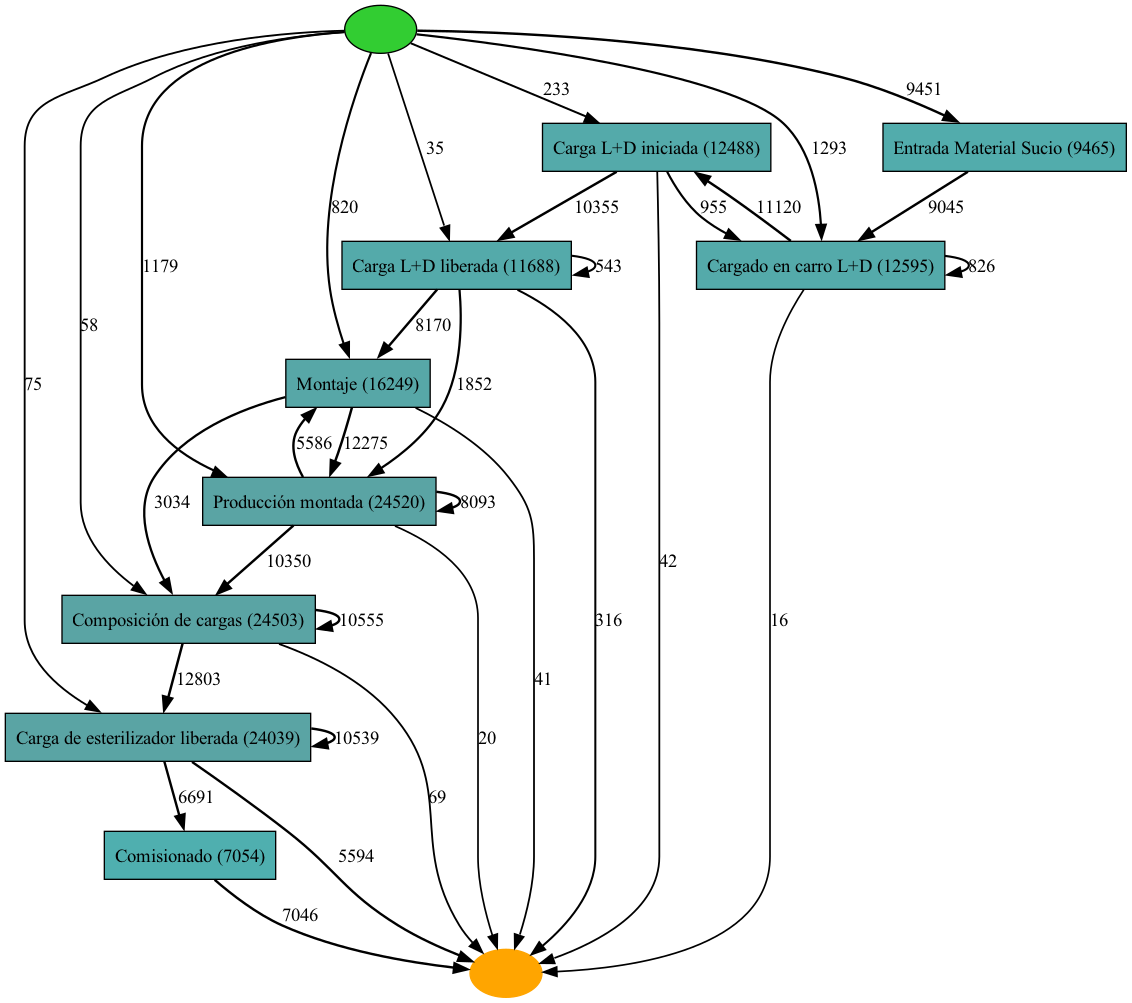

In [217]:
heu_net = pm4py.discover_heuristics_net(event_log, dependency_threshold=0.9)
pm4py.view_heuristics_net(heu_net)

In [218]:
df = pm4py.convert_to_dataframe(event_log)
df.head()

,concept:name,Nombre,KitID,resource,time:timestamp,Codigo,NS,@@index,case:concept:name
0,Montaje,Pinza Duckling Right 45,012047 L2901-0,CM,2022-01-26 17:31:00+00:00,012047 L2901,0,103335,012047 L2901-0-CN10738
1,Montaje,Pinza Duckling Right 45,012047 L2901-0,SM,2022-01-28 08:16:00+00:00,012047 L2901,0,103334,012047 L2901-0-CN10738
2,Montaje,Pinza Duckling Right 45,012047 L2901-0,CM,2022-01-04 16:00:00+00:00,012047 L2901,0,103338,012047 L2901-0-CN1080
3,Montaje,Pinza Duckling Right 45,012047 L2901-0,CM,2022-01-05 14:04:00+00:00,012047 L2901,0,103337,012047 L2901-0-CN1080
4,Producción montada,Pinza Duckling Right 45,012047 L2901-0,CM,2022-01-05 14:04:00+00:00,012047 L2901,0,103339,012047 L2901-0-CN1080


In [219]:
segments = []
df = df.sort_values(['case:concept:name', 'time:timestamp', 'concept:name'])

result = pd.concat([df, df.shift(-1)], axis=1)
result.columns = [str(i) + str(k // (len(df.columns))) for k, i in enumerate(result.columns)]
result = result[result['case:concept:name0'] == result['case:concept:name1']]

result['segment_name'] = result['concept:name0'] + ' - ' + result['concept:name1']
result.drop(['concept:name0', 'case:concept:name1', 'concept:name1'], axis=1, inplace=True)
result.columns = ['start_' + i.split('0')[0] if '0' in i else ('end_' + i.split('1')[0] if '1' in i else i) for i in result.columns]

segments = result['segment_name'].unique()
result.head()

,start_Nombre,start_KitID,start_resource,start_time:timestamp,start_Codigo,start_NS,start_@@index,start_case:concept:name,end_Nombre,end_KitID,end_resource,end_time:timestamp,end_Codigo,end_NS,end_@@index,segment_name
0,Pinza Duckling Right 45,012047 L2901-0,CM,2022-01-26 17:31:00+00:00,012047 L2901,0,103335,012047 L2901-0-CN10738,Pinza Duckling Right 45,012047 L2901-0,SM,2022-01-28 08:16:00+00:00,012047 L2901,0.0,103334.0,Montaje - Montaje
2,Pinza Duckling Right 45,012047 L2901-0,CM,2022-01-04 16:00:00+00:00,012047 L2901,0,103338,012047 L2901-0-CN1080,Pinza Duckling Right 45,012047 L2901-0,CM,2022-01-05 14:04:00+00:00,012047 L2901,0.0,103337.0,Montaje - Montaje
3,Pinza Duckling Right 45,012047 L2901-0,CM,2022-01-05 14:04:00+00:00,012047 L2901,0,103337,012047 L2901-0-CN1080,Pinza Duckling Right 45,012047 L2901-0,CM,2022-01-05 14:04:00+00:00,012047 L2901,0.0,103339.0,Montaje - Producción montada
4,Pinza Duckling Right 45,012047 L2901-0,CM,2022-01-05 14:04:00+00:00,012047 L2901,0,103339,012047 L2901-0-CN1080,Pinza Duckling Right 45,012047 L2901-0,CM,2022-01-07 13:06:00+00:00,012047 L2901,0.0,103336.0,Producción montada - Montaje
5,Pinza Duckling Right 45,012047 L2901-0,CM,2022-01-07 13:06:00+00:00,012047 L2901,0,103336,012047 L2901-0-CN1080,Pinza Duckling Right 45,012047 L2901-0,CM,2022-01-07 13:06:00+00:00,012047 L2901,0.0,103340.0,Montaje - Producción montada


In [220]:
result['durationMinutes'] = (result['end_time:timestamp'] - result['start_time:timestamp']).dt.total_seconds() / 60 

In [221]:
Q1 = result.groupby('segment_name')['durationMinutes'].quantile(0.25)
Q3 = result.groupby('segment_name')['durationMinutes'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

result_filtered = result[~result.apply(lambda x: (x['durationMinutes'] < lower_bound[x['segment_name']]) or 
                                              (x['durationMinutes'] > upper_bound[x['segment_name']]), axis=1)]

grouped = result_filtered.groupby('segment_name')['durationMinutes'].describe()
grouped.sort_values('count', ascending=False).head()

,count,mean,std,min,25%,50%,75%,max
segment_name,,,,,,,,
Montaje - Producción montada,13855.0,0.833995,1.376298,0.0,0.0,0.0,1.0,5.0
Producción montada - Composición de cargas,12457.0,34.050413,29.991607,1.0,10.0,25.0,50.0,128.0
Composición de cargas - Carga de esterilizador liberada,11123.0,103.691630,20.042986,47.0,91.0,104.0,115.0,166.0
Carga de esterilizador liberada - Carga de esterilizador liberada,10228.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Cargado en carro L+D - Carga L+D iniciada,10195.0,15.355370,16.054900,1.0,2.0,9.0,25.0,66.0


In [222]:
trace_frequency = Counter()
for trace in event_log:
    trace_id = tuple(event["concept:name"] for event in trace)
    trace_frequency[trace_id] += 1

min_frequency = 10  

filtered_event_log = EventLog()
for trace in event_log:
    trace_id = tuple(event["concept:name"] for event in trace)
    if trace_frequency[trace_id] >= min_frequency:
        filtered_event_log.append(trace)
len(pm4py.get_variants_as_tuples(filtered_event_log))

92

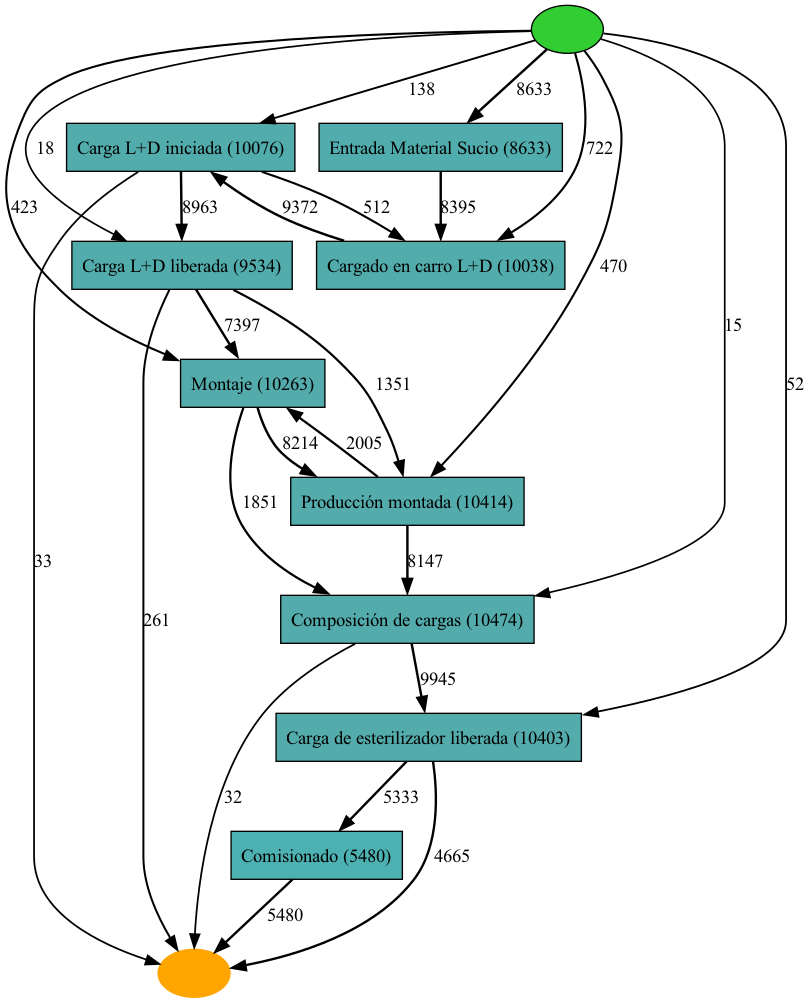

In [223]:
heu_net = pm4py.discover_heuristics_net(filtered_event_log, dependency_threshold=0.9)
pm4py.view_heuristics_net(heu_net)